In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.cross_decomposition import CCA



In [20]:
root = '.'
train_ratio = 1.0
test_ratio = 0.3

## Preprocessing for ridge regression and CCA

In [ ]:
dataset_path = f"{root}/dataset_400parcels_2.nc"
targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

dataset = MatData(dataset_path, targets, synth_exp = False, threshold=0)

n_sub = len(dataset)
indices = np.arange(n_sub)

train_size = int(n_sub * (1 - test_ratio) * train_ratio)
test_size = int(test_ratio * n_sub)
run_size = test_size + train_size

random_state = np.random.RandomState(seed=42)
run_indices = random_state.choice(indices, run_size, replace=False)
train_indices, test_indices = train_test_split(run_indices, test_size=0.3, random_state=random_state)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

X_train = train_dataset.dataset.matrices[train_dataset.indices].numpy()
X_train = sym_matrix_to_vec(X_train, discard_diagonal=True)
y_train = train_dataset.dataset.target[train_dataset.indices].squeeze().numpy()
X_test = test_dataset.dataset.matrices[test_dataset.indices].numpy()
X_test = sym_matrix_to_vec(X_test, discard_diagonal=True)
y_test = test_dataset.dataset.target[test_dataset.indices].squeeze().numpy()


## CV Ridge regression

In [4]:
ridge_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
            scoring="r2")

pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

fitted_pipe = pipe_ridge.fit(X_train, y_train)

y_train_pred = fitted_pipe.predict(X_train)
y_test_pred = fitted_pipe.predict(X_test)



In [5]:
train_df = pd.DataFrame(y_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(y_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

# Combine train and test results into a single DataFrame
results_ridge_df = pd.concat([train_results_df, test_results_df]).reset_index(drop=True)
results_ridge_df

,age,benton_faces,cardio_measure_pulse_mean,cardio_measure_bp_sys_mean,cardio_measure_bp_dia_mean,cattell,famous_faces,hotel_time,picture_priming_baseline_acc,picture_priming_baseline_rt,...,rt_choice_pred,rt_simple_pred,syn_sem_prop_error_pred,syn_sem_rt_pred,tip_of_tongue_pred,VSTM_colour_K_mean_pred,VSTM_colour_K_precision_pred,VSTM_colour_K_doubt_pred,VSTM_colour_MSE_pred,dataset
0,61.0,24.0,70.0,114.0,74.5,33.0,0.950000,291.309998,0.795238,899.0,...,0.685574,0.581069,0.122808,1765.596924,0.657142,2.000680,0.590643,46.230064,2346.054443,train
1,34.0,25.0,64.5,102.5,67.5,36.0,1.000000,480.000000,0.842857,886.0,...,0.588591,0.377661,0.071430,1820.000122,0.000003,2.239262,0.563594,8.501884,1532.454468,train
2,69.0,21.0,72.0,128.5,73.5,26.0,0.810345,380.279999,0.595238,798.0,...,0.784933,0.591138,0.214285,1520.999390,0.914281,1.647090,0.402744,15.524997,3887.708496,train
3,78.0,21.0,88.5,136.0,81.5,38.0,0.964286,193.220001,0.780952,880.0,...,0.555048,0.354173,0.047621,1587.300659,0.257146,2.219351,0.384937,35.581951,2316.064697,train
4,54.0,24.0,66.5,120.0,75.5,23.0,0.933333,480.000000,0.866667,907.0,...,0.617227,0.361150,0.072683,1919.297729,0.472223,1.518454,0.630216,9.526854,4299.219238,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,32.0,23.0,70.0,95.5,66.5,35.0,0.983333,240.000000,0.795238,854.0,...,0.544469,0.349463,0.167768,1520.072144,0.493746,2.225847,0.471387,31.900906,2014.353760,test
347,45.0,24.0,89.5,132.5,82.5,35.0,0.982759,106.220001,0.866667,787.0,...,0.534521,0.321983,0.261273,1321.757690,0.298498,1.970203,0.465262,24.010653,2626.443359,test
348,29.0,21.0,73.5,110.5,81.0,37.0,1.000000,223.779999,0.852381,725.0,...,0.499963,0.314857,0.211423,1448.266479,0.264246,2.055787,0.504039,19.895662,2451.148926,test
349,36.0,25.0,54.5,133.5,70.0,38.0,0.950000,254.720001,0.904762,910.0,...,0.557632,0.385590,0.241443,1653.052368,0.603134,2.206059,0.436584,30.188442,2106.095215,test


## CCA


In [6]:
# Define the pipeline with CCA
n_components = min(len(targets), X_train.shape[1])  # CCA components <= min(n_features, n_targets)

pipe_cca = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features and targets
    ('cca', CCA(n_components=n_components))
])

# Fit the pipeline
pipe_cca.fit(X_train, y_train)
cca_model = pipe_cca.named_steps['cca']


# Transform the data and predict
#X_train_cca, y_train_cca = cca_model.transform(X_train, y_train)  # Transform the features
#X_test_cca, y_test_cca = cca_model.transform(X_test, y_test) 

y_train_pred = cca_model.predict(X_train)
y_test_pred = cca_model.predict(X_test)



In [7]:
# Create result DataFrames
train_df = pd.DataFrame(y_train, columns=targets)
train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
train_results_df = pd.concat([train_df, train_pred_df], axis=1)
train_results_df["dataset"] = "train"

test_df = pd.DataFrame(y_test, columns=targets)
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
test_results_df = pd.concat([test_df, test_pred_df], axis=1)
test_results_df["dataset"] = "test"

# Combine train and test results into a single DataFrame
results_cca_df = pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

# Display the results DataFrame
results_cca_df

,age,benton_faces,cardio_measure_pulse_mean,cardio_measure_bp_sys_mean,cardio_measure_bp_dia_mean,cattell,famous_faces,hotel_time,picture_priming_baseline_acc,picture_priming_baseline_rt,...,rt_choice_pred,rt_simple_pred,syn_sem_prop_error_pred,syn_sem_rt_pred,tip_of_tongue_pred,VSTM_colour_K_mean_pred,VSTM_colour_K_precision_pred,VSTM_colour_K_doubt_pred,VSTM_colour_MSE_pred,dataset
0,61.0,24.0,70.0,114.0,74.5,33.0,0.950000,291.309998,0.795238,899.0,...,0.555523,1.070855,0.455882,3065.152257,1.269368,0.927578,1.187267,132.277649,5252.716577,train
1,34.0,25.0,64.5,102.5,67.5,36.0,1.000000,480.000000,0.842857,886.0,...,0.357053,0.247800,0.185798,3463.409325,-1.534608,2.302807,0.971634,5.984203,444.739005,train
2,69.0,21.0,72.0,128.5,73.5,26.0,0.810345,380.279999,0.595238,798.0,...,1.161248,1.078842,0.708959,1574.282960,2.727247,-0.475799,0.381552,-3.441099,10507.201668,train
3,78.0,21.0,88.5,136.0,81.5,38.0,0.964286,193.220001,0.780952,880.0,...,0.505212,0.265304,0.183051,2769.927407,-0.530824,2.004604,0.152622,95.698701,4738.405927,train
4,54.0,24.0,66.5,120.0,75.5,23.0,0.933333,480.000000,0.866667,907.0,...,0.331096,0.453556,0.285561,4294.168454,0.308797,-1.176648,1.413736,19.194219,13861.872172,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,32.0,23.0,70.0,95.5,66.5,35.0,0.983333,240.000000,0.795238,854.0,...,0.290336,0.155342,0.441440,1485.539344,0.368742,2.289300,0.651425,78.230238,1793.119375,test
347,45.0,24.0,89.5,132.5,82.5,35.0,0.982759,106.220001,0.866667,787.0,...,0.225798,0.078347,0.875274,1109.495623,-0.337639,1.287723,0.546633,52.719336,4482.630995,test
348,29.0,21.0,73.5,110.5,81.0,37.0,1.000000,223.779999,0.852381,725.0,...,0.104520,0.149796,0.686839,1706.517107,-0.498033,1.341559,0.736995,46.748246,4927.760321,test
349,36.0,25.0,54.5,133.5,70.0,38.0,0.950000,254.720001,0.904762,910.0,...,0.321525,0.347522,0.861293,2413.074132,0.736329,2.236107,0.400639,71.646149,2714.737581,test


## Our model

In [17]:
#exp_name = "strong pretraining, 4 layer decoder, 19 targets, 3 augmentations"
exp_name = "final model train ratio 0.5"
prediction_model = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

In [18]:
train_count = prediction_model[prediction_model["dataset"] == "train"].shape[0]
train_count

246

In [10]:
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_predict

# Define the targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Split the data into training and testing sets
train_data = prediction_model[prediction_model["dataset"] == "train"]
test_data = prediction_model[prediction_model["dataset"] == "test"]

# Prepare the results dataframe
results = []

# Perform Ridge regression for each target
for target in targets:
    # Extract the predicted features (X) and original target values (y)
    train_X = train_data[[f"{t}_pred" for t in targets]]
    train_y = train_data[target]
    test_X = test_data[[f"{t}_pred" for t in targets]]
    
    # Train Ridge regression with cross-validation
    ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
    ridge.fit(train_X, train_y)
    
    # Predict on both train and test sets
    train_pred = ridge.predict(train_X)
    test_pred = ridge.predict(test_X)
    
    # Append results for the train dataset
    train_results = pd.DataFrame({
        target: train_y.values,
        f"{target}_pred": train_pred,
        "dataset": "train"
    })
    # Append results for the test dataset
    test_results = pd.DataFrame({
        target: test_data[target].values,
        f"{target}_pred": test_pred,
        "dataset": "test"
    })
    
    # Combine results
    results.append(pd.concat([train_results, test_results], ignore_index=True))

# Combine all results into a single DataFrame
final_results = pd.concat(results, axis=1)

# Drop duplicate columns for 'dataset' and ensure one dataset column
final_results = final_results.loc[:, ~final_results.columns.duplicated()]


In [11]:
final_results

,benton_faces,benton_faces_pred,dataset,cattell,cattell_pred,famous_faces,famous_faces_pred,hotel_time,hotel_time_pred,picture_priming_baseline_acc,...,tip_of_tongue,tip_of_tongue_pred,VSTM_colour_K_mean,VSTM_colour_K_mean_pred,VSTM_colour_K_precision,VSTM_colour_K_precision_pred,VSTM_colour_K_doubt,VSTM_colour_K_doubt_pred,VSTM_colour_MSE,VSTM_colour_MSE_pred
0,21.000002,23.928659,train,43.000004,44.848801,1.964285,1.983150,207.619950,209.409738,1.914285,...,1.368421,1.373982,3.445632,3.391392,1.551437,1.571854,41.378580,39.506687,1117.78820,1113.558124
1,24.000000,25.430994,train,42.000000,41.255300,1.933333,1.907276,142.760030,143.590325,1.871429,...,1.333333,1.335835,3.535944,3.559572,1.543763,1.556939,25.744633,26.105953,697.11993,707.019211
2,24.000000,24.017535,train,42.000000,41.790997,1.666667,1.786164,259.749970,242.994382,1.785714,...,1.000000,1.034396,3.405833,3.369708,1.595672,1.590306,11.935720,11.699730,1132.69130,1189.274581
3,24.999998,25.894679,train,44.000004,43.545880,2.000000,2.026381,169.659990,198.613024,1.938095,...,1.400000,1.386508,3.173543,3.199421,1.519179,1.530108,45.430363,46.000693,1857.46360,1853.623489
4,24.000000,24.023705,train,39.999996,40.101655,1.966667,1.955894,226.469960,238.750975,1.852381,...,1.166667,1.158352,3.475832,3.483954,1.609366,1.554877,50.216070,45.640133,768.01070,892.605566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,26.000002,25.344785,test,37.999996,33.280202,1.966667,1.923751,25.249996,188.998208,1.861905,...,1.461539,1.405937,3.353984,2.953664,1.484701,1.487926,9.812506,10.307249,1609.11350,2632.367979
348,23.000000,23.749332,test,31.000000,26.663083,1.724138,1.821773,401.280060,441.905382,1.547619,...,1.863636,1.671577,3.166916,2.920959,1.384309,1.427866,45.080360,15.803237,2355.02780,3005.149268
349,20.000004,24.357440,test,32.000004,29.056757,1.827586,1.907278,166.630040,246.152590,1.704762,...,1.787879,1.456694,3.105691,2.702184,1.393551,1.452025,22.703562,9.469169,2480.94000,3594.509425
350,24.000000,25.037415,test,29.000004,36.080323,1.900000,1.904524,175.909990,275.033202,1.809524,...,1.600000,1.442153,3.392102,3.092491,1.364562,1.473294,41.435720,18.716686,2053.83570,2296.789994


## Plotting

/tmp/ipykernel_767230/1969714849.py:116: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


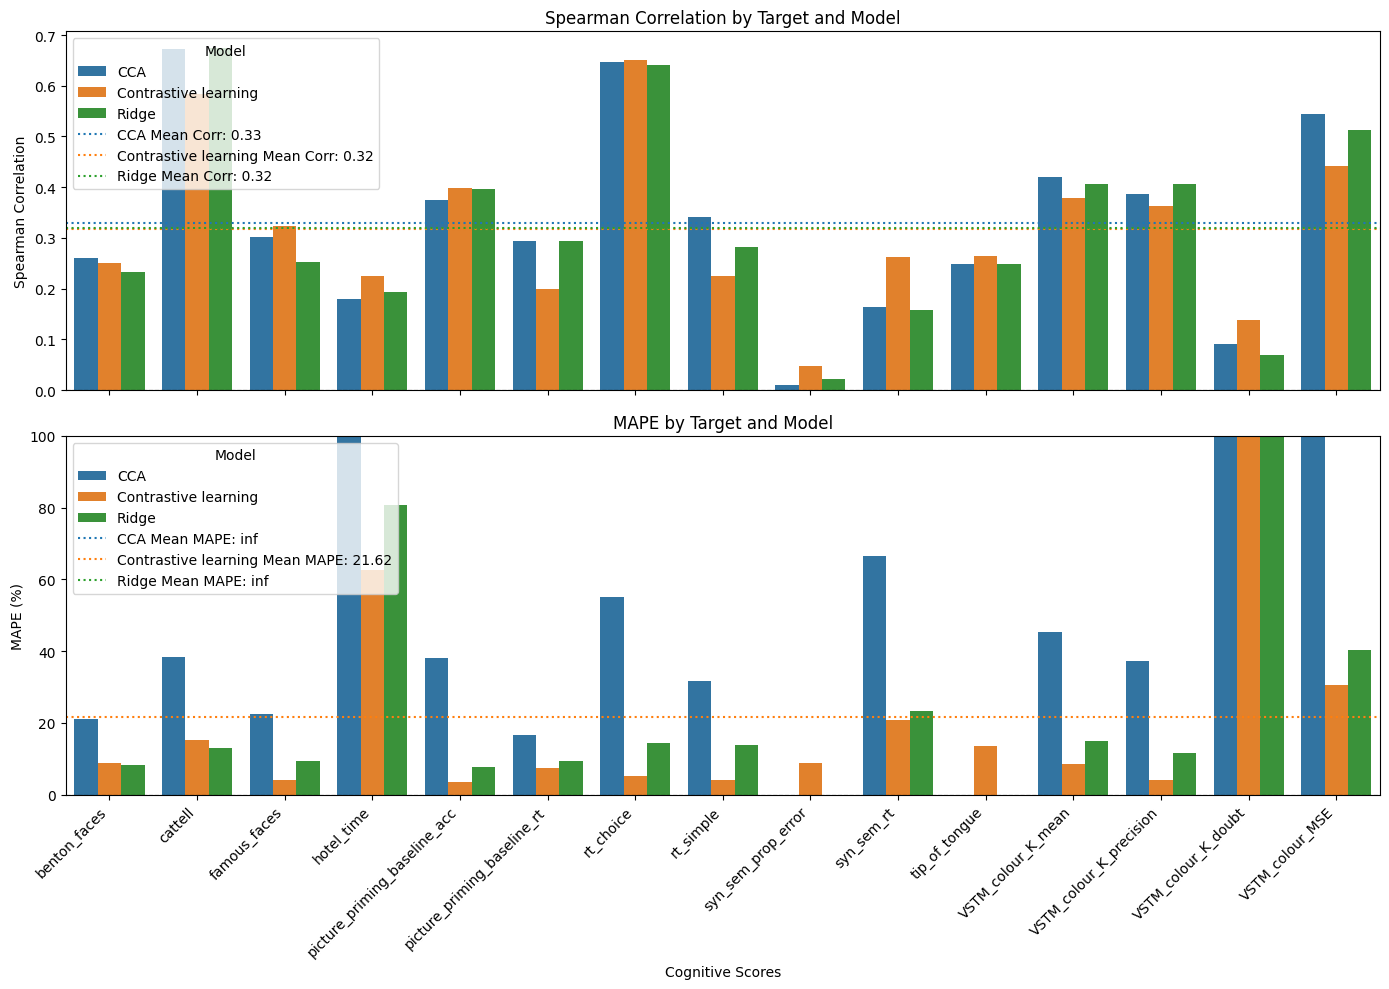

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

# List of targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Combine all datasets into one for easier processing
all_results = pd.concat(
    [
        results_ridge_df.assign(model="Ridge"),
        results_cca_df.assign(model="CCA"),
        prediction_model.assign(model="Contrastive learning"),
        #final_results.assign(model = "contrastive learning + ridge regression")
    ],
    ignore_index=True,
)

# Compute Spearman correlation and MAPE for each target in the test set
results = []
for model, group in all_results.groupby("model"):
    test_data = group[group["dataset"] == "test"]

    for target in targets:
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]

            # Avoid issues with empty or NaN values
            if not true_values.isna().all() and not predicted_values.isna().all():

                # Spearman correlation
                spearman_corr = spearmanr(true_values, predicted_values)[0]

                # MAPE (Mean Absolute Percentage Error)
                mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                results.append(
                    {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                )

results_df = pd.DataFrame(results)

# Compute mean correlation and MAPE for each model
mean_stats = results_df.groupby("model")[["spearman_corr", "mape"]].mean().reset_index()
mean_stats.rename(columns={"spearman_corr": "mean_corr", "mape": "mean_mape"}, inplace=True)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Spearman correlation plot
sns.barplot(
    data=results_df,
    x="target",
    y="spearman_corr",
    hue="model",
    ax=axes[0],
    palette="tab10",
)
axes[0].set_title("Spearman Correlation by Target and Model")
axes[0].set_ylabel("Spearman Correlation")
axes[0].set_xlabel("")
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean Spearman correlation
palette = sns.color_palette("tab10")
model_colors = {
    model: palette[i] for i, model in enumerate(mean_stats["model"])
}
for model, row in mean_stats.iterrows():
    axes[0].axhline(
        row["mean_corr"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Mean Corr: {row['mean_corr']:.2f}",
    )

# Update legend
axes[0].legend(title="Model", loc="upper left")

# MAPE plot
sns.barplot(
    data=results_df,
    x="target",
    y="mape",
    hue="model",
    ax=axes[1],
    palette="tab10",
)
axes[1].set_title("MAPE by Target and Model")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_xlabel("Cognitive Scores")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean MAPE
for model, row in mean_stats.iterrows():
    axes[1].axhline(
        row["mean_mape"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Mean MAPE: {row['mean_mape']:.2f}",
    )

# Limit MAPE y-axis to 100
axes[1].set_ylim(0, 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Update legend
axes[1].legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()

/tmp/ipykernel_767230/1897338716.py:109: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


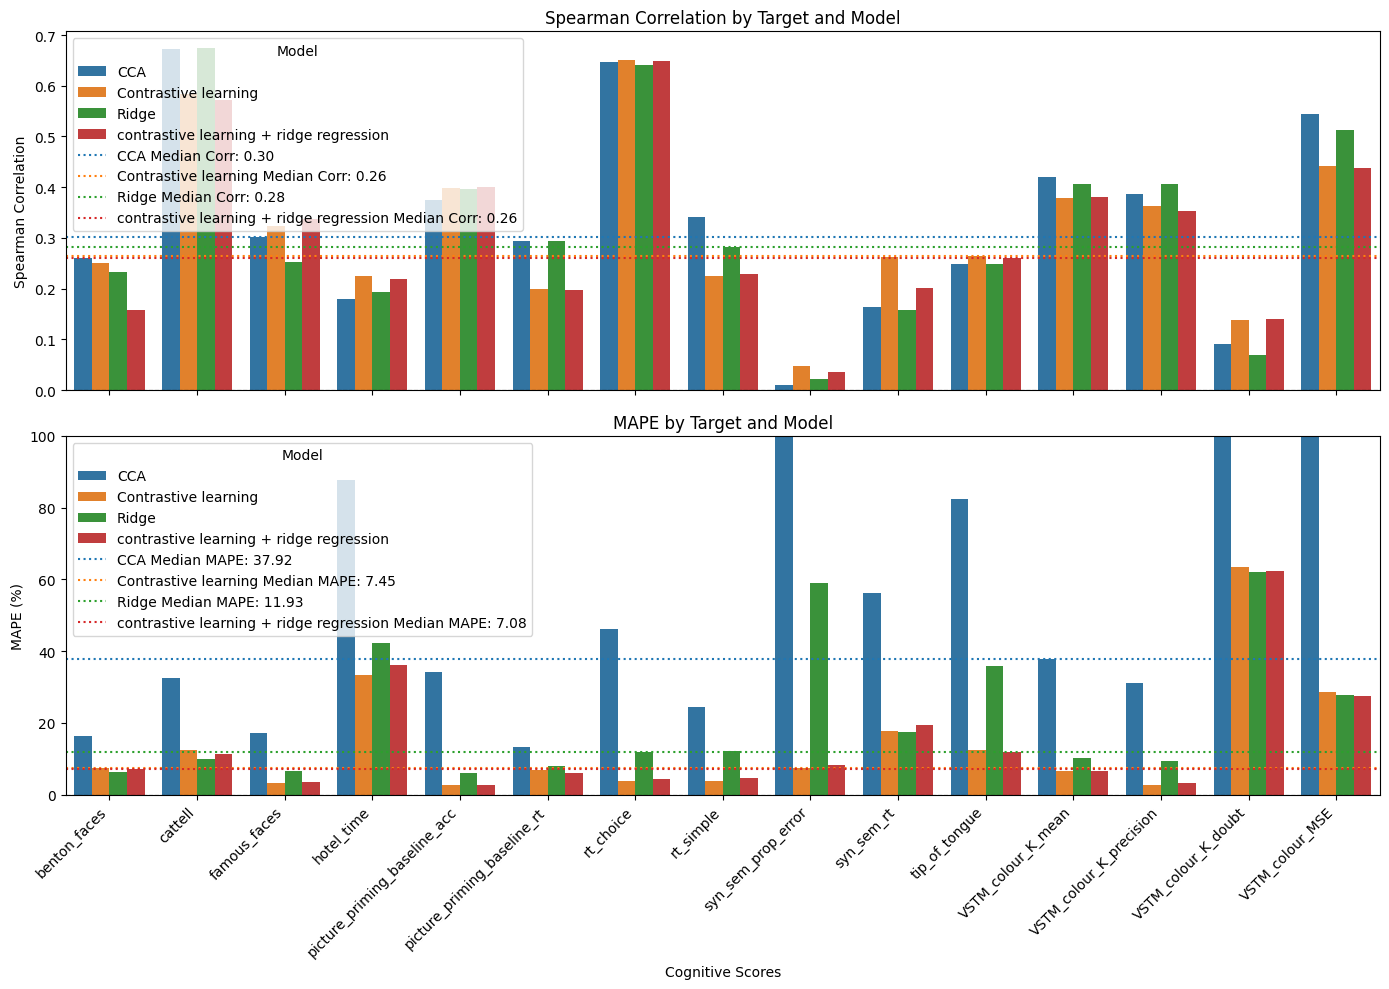

In [13]:

# List of targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Combine all datasets into one for easier processing
all_results = pd.concat(
    [
        results_ridge_df.assign(model="Ridge"),
        results_cca_df.assign(model="CCA"),
        prediction_model.assign(model="Contrastive learning"),
        final_results.assign(model = "contrastive learning + ridge regression")
    ],
    ignore_index=True,
)

# Compute Spearman correlation and MAPE for each target in the test set
results = []
for model, group in all_results.groupby("model"):
    test_data = group[group["dataset"] == "test"]

    for target in targets:
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]

            # Avoid issues with empty or NaN values
            if not true_values.isna().all() and not predicted_values.isna().all():
                # Spearman correlation
                spearman_corr = spearmanr(true_values, predicted_values)[0]

                # MAPE (Mean Absolute Percentage Error)
                mape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100

                results.append(
                    {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                )

results_df = pd.DataFrame(results)

# Compute median correlation and MAPE for each model
median_stats = results_df.groupby("model")[["spearman_corr", "mape"]].median().reset_index()
median_stats.rename(columns={"spearman_corr": "median_corr", "mape": "median_mape"}, inplace=True)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Spearman correlation plot
sns.barplot(
    data=results_df,
    x="target",
    y="spearman_corr",
    hue="model",
    ax=axes[0],
    palette="tab10",
)
axes[0].set_title("Spearman Correlation by Target and Model")
axes[0].set_ylabel("Spearman Correlation")
axes[0].set_xlabel("")
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for median Spearman correlation
palette = sns.color_palette("tab10")
model_colors = {
    model: palette[i] for i, model in enumerate(median_stats["model"])
}
for model, row in median_stats.iterrows():
    axes[0].axhline(
        row["median_corr"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median Corr: {row['median_corr']:.2f}",
    )

# Update legend
axes[0].legend(title="Model", loc="upper left")

# MAPE plot
sns.barplot(
    data=results_df,
    x="target",
    y="mape",
    hue="model",
    ax=axes[1],
    palette="tab10",
)
axes[1].set_title("MAPE by Target and Model")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_xlabel("Cognitive Scores")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for median MAPE
for model, row in median_stats.iterrows():
    axes[1].axhline(
        row["median_mape"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median MAPE: {row['median_mape']:.2f}",
    )

# Limit MAPE y-axis to 100
axes[1].set_ylim(0, 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Update legend
axes[1].legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()


/tmp/ipykernel_767230/1415683022.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


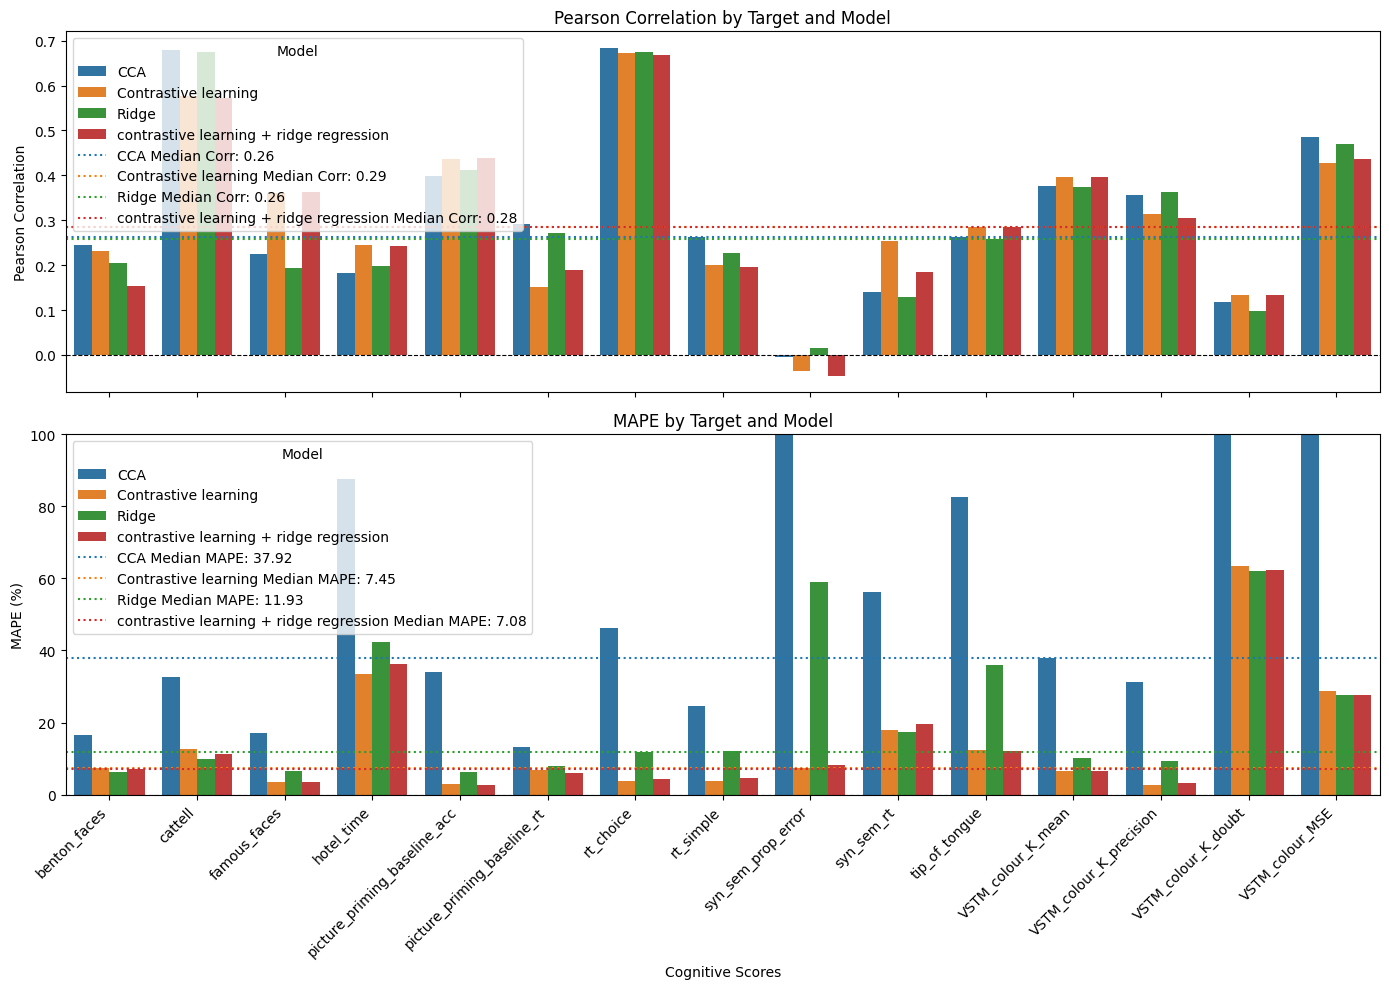

In [14]:
# Compute Pearson correlation and MAPE for each target in the test set
results = []
for model, group in all_results.groupby("model"):
    test_data = group[group["dataset"] == "test"]

    for target in targets:
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]

            # Avoid issues with empty or NaN values
            if not true_values.isna().all() and not predicted_values.isna().all():
                # Pearson correlation
                pearson_corr = np.corrcoef(true_values, predicted_values)[0, 1]

                # MAPE (Median Absolute Percentage Error)
                mape = np.median(np.abs((true_values - predicted_values) / true_values)) * 100

                results.append(
                    {"model": model, "target": target, "pearson_corr": pearson_corr, "mape": mape}
                )

results_df = pd.DataFrame(results)

# Compute median correlation and MAPE for each model
median_stats = results_df.groupby("model")[["pearson_corr", "mape"]].median().reset_index()
median_stats.rename(columns={"pearson_corr": "median_corr", "mape": "median_mape"}, inplace=True)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Pearson correlation plot
sns.barplot(
    data=results_df,
    x="target",
    y="pearson_corr",
    hue="model",
    ax=axes[0],
    palette="tab10",
)
axes[0].set_title("Pearson Correlation by Target and Model")
axes[0].set_ylabel("Pearson Correlation")
axes[0].set_xlabel("")
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for median Pearson correlation
palette = sns.color_palette("tab10")
model_colors = {
    model: palette[i] for i, model in enumerate(median_stats["model"])
}
for model, row in median_stats.iterrows():
    axes[0].axhline(
        row["median_corr"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median Corr: {row['median_corr']:.2f}",
    )

# Update legend
axes[0].legend(title="Model", loc="upper left")

# MAPE plot
sns.barplot(
    data=results_df,
    x="target",
    y="mape",
    hue="model",
    ax=axes[1],
    palette="tab10",
)
axes[1].set_title("MAPE by Target and Model")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_xlabel("Cognitive Scores")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for median MAPE
for model, row in median_stats.iterrows():
    axes[1].axhline(
        row["median_mape"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median MAPE: {row['median_mape']:.2f}",
    )

# Limit MAPE y-axis to 100
axes[1].set_ylim(0, 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Update legend
axes[1].legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()


/tmp/ipykernel_473627/3730937979.py:129: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


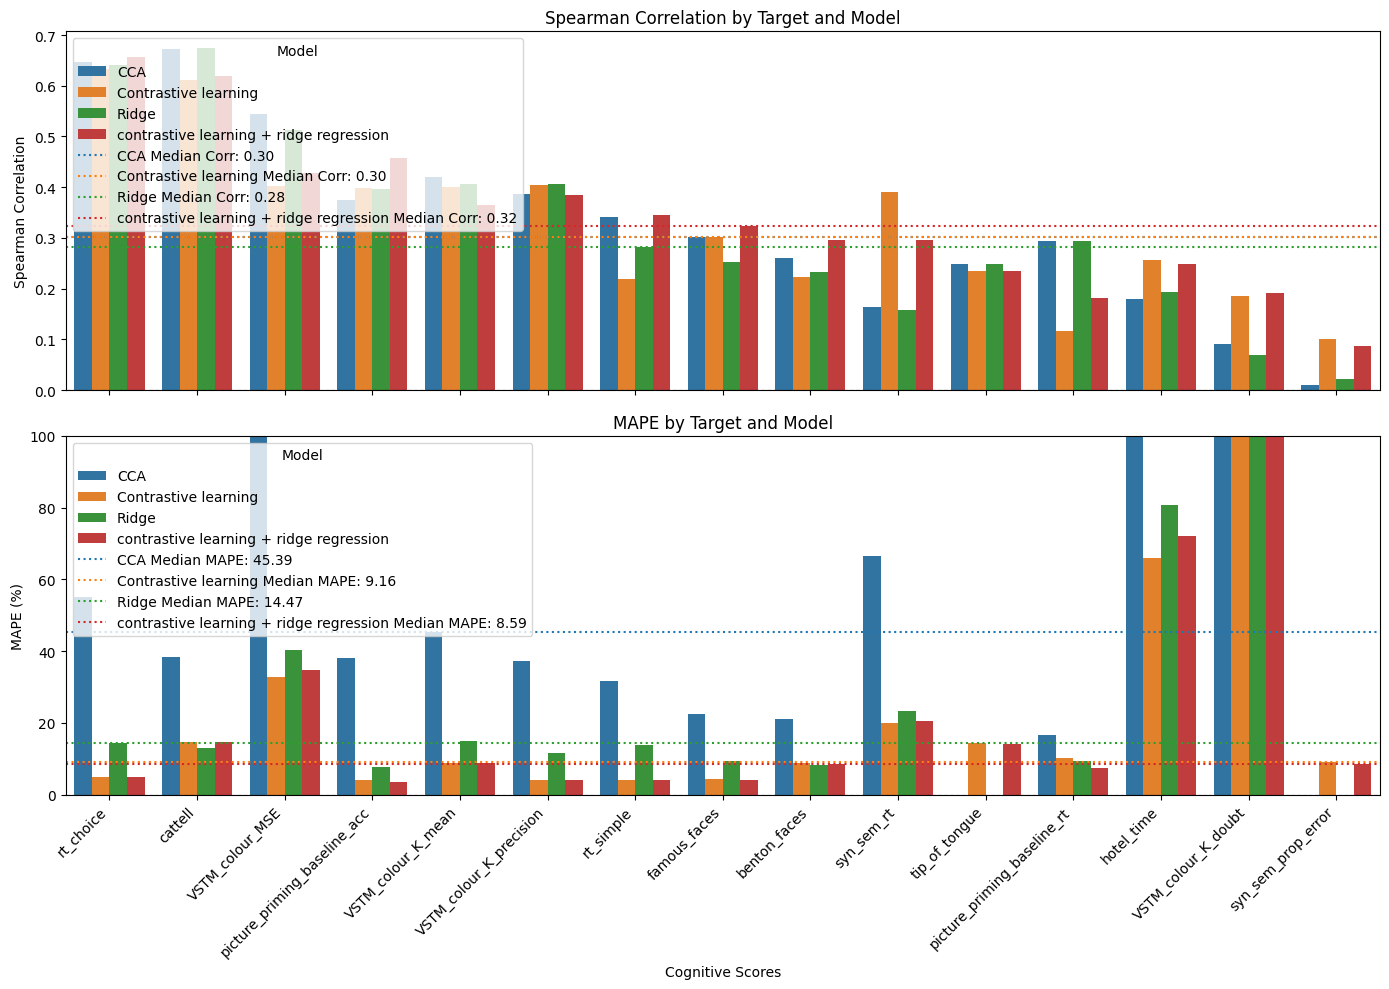

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np



# List of targets
targets = [
    "benton_faces", "cattell", "famous_faces", "hotel_time",
    "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
    "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", 
    "VSTM_colour_K_mean", "VSTM_colour_K_precision", "VSTM_colour_K_doubt", 
    "VSTM_colour_MSE"
]

# Combine all datasets into one for easier processing
all_results = pd.concat(
    [
        results_ridge_df.assign(model="Ridge"),
        results_cca_df.assign(model="CCA"),
        prediction_model.assign(model="Contrastive learning"),
        final_results.assign(model = "contrastive learning + ridge regression")
    ],
    ignore_index=True,
)

# Compute Spearman correlation and MAPE for each target in the test set
results = []
for model, group in all_results.groupby("model"):
    test_data = group[group["dataset"] == "test"]

    for target in targets:
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]

            # Avoid issues with empty or NaN values
            if not true_values.isna().all() and not predicted_values.isna().all():

                # Spearman correlation
                spearman_corr = spearmanr(true_values, predicted_values)[0]

                # MAPE (Mean Absolute Percentage Error)
                mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                results.append(
                    {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                )

results_df = pd.DataFrame(results)

# Compute median correlation and MAPE for each model
mean_stats = results_df.groupby("model")[["spearman_corr", "mape"]].median().reset_index()
mean_stats.rename(columns={"spearman_corr": "median_corr", "mape": "median_mape"}, inplace=True)

# Calculate mean Spearman correlation and MAPE for each target across all models
target_stats = results_df.groupby("target")[["spearman_corr", "mape"]].mean().reset_index()

# Rank targets by mean Spearman correlation or MAPE
target_stats["spearman_corr_rank"] = target_stats["spearman_corr"].rank(ascending=False)
target_stats["mape_rank"] = target_stats["mape"].rank(ascending=True)

# Sorting targets by rank (use "spearman_corr_rank" or "mape_rank" for sorting)
sorted_targets_by_corr = target_stats.sort_values(by="spearman_corr_rank")["target"].tolist()
sorted_targets_by_mape = target_stats.sort_values(by="mape_rank")["target"].tolist()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Spearman correlation plot (sorted by Spearman correlation)
sns.barplot(
    data=results_df,
    x="target",
    y="spearman_corr",
    hue="model",
    ax=axes[0],
    palette="tab10",
    order=sorted_targets_by_corr  # Order by Spearman correlation rank
)
axes[0].set_title("Spearman Correlation by Target and Model")
axes[0].set_ylabel("Spearman Correlation")
axes[0].set_xlabel("")
axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean Spearman correlation
palette = sns.color_palette("tab10")
model_colors = {
    model: palette[i] for i, model in enumerate(mean_stats["model"])
}
for model, row in mean_stats.iterrows():
    axes[0].axhline(
        row["median_corr"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median Corr: {row['median_corr']:.2f}",
    )

# Update legend
axes[0].legend(title="Model", loc="upper left")

# MAPE plot (sorted by MAPE)
sns.barplot(
    data=results_df,
    x="target",
    y="mape",
    hue="model",
    ax=axes[1],
    palette="tab10",
    order=sorted_targets_by_mape  # Order by MAPE rank
)
axes[1].set_title("MAPE by Target and Model")
axes[1].set_ylabel("MAPE (%)")
axes[1].set_xlabel("Cognitive Scores")
axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

# Add dotted lines for mean MAPE
for model, row in mean_stats.iterrows():
    axes[1].axhline(
        row["median_mape"],
        color=model_colors[row["model"]],
        linestyle=":",
        linewidth=1.5,
        label=f"{row['model']} Median MAPE: {row['median_mape']:.2f}",
    )

# Limit MAPE y-axis to 100
axes[1].set_ylim(0, 100)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

# Update legend
axes[1].legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()


In [38]:
def plot_scores(ridge, cca, model, targets):
    all_results = pd.concat(
    [
        ridge.assign(model="Ridge"),
        cca.assign(model="CCA"),
        model.assign(model="Contrastive learning"),
    ],
    ignore_index=True,
    )

    # Compute Spearman correlation and MAPE for each target in the test set
    results = []
    for model, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]

        for target in targets:
            if target in test_data.columns:
                true_values = test_data[target]
                predicted_values = test_data[f"{target}_pred"]

                # Avoid issues with empty or NaN values
                if not true_values.isna().all() and not predicted_values.isna().all():

                    # Spearman correlation
                    spearman_corr = spearmanr(true_values, predicted_values)[0]
                    # MAPE (Mean Absolute Percentage Error)
                    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                    results.append(
                        {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                    )

    results_df = pd.DataFrame(results)

    # Compute median correlation and MAPE for each model
    mean_stats = results_df.groupby("model")[["spearman_corr", "mape"]].mean().reset_index()
    mean_stats.rename(columns={"spearman_corr": "mean_corr", "mape": "mean_mape"}, inplace=True)

    # Calculate mean Spearman correlation and MAPE for each target across all models
    target_stats = results_df.groupby("target")[["spearman_corr", "mape"]].mean().reset_index()

    # Rank targets by mean Spearman correlation or MAPE
    target_stats["spearman_corr_rank"] = target_stats["spearman_corr"].rank(ascending=False)
    target_stats["mape_rank"] = target_stats["mape"].rank(ascending=True)

    # Sorting targets by rank (use "spearman_corr_rank" or "mape_rank" for sorting)
    sorted_targets_by_corr = target_stats.sort_values(by="spearman_corr_rank")["target"].tolist()
    sorted_targets_by_mape = target_stats.sort_values(by="mape_rank")["target"].tolist()

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Spearman correlation plot (sorted by Spearman correlation)
    sns.barplot(
        data=results_df,
        x="target",
        y="spearman_corr",
        hue="model",
        ax=axes[0],
        palette="tab10",
        order=sorted_targets_by_corr  # Order by Spearman correlation rank
    )
    axes[0].set_title("Spearman Correlation by Target and Model")
    axes[0].set_ylabel("Spearman Correlation")
    axes[0].set_xlabel("")
    axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add dotted lines for mean Spearman correlation
    palette = sns.color_palette("tab10")
    model_colors = {
        model: palette[i] for i, model in enumerate(mean_stats["model"])
    }
    for model, row in mean_stats.iterrows():
        axes[0].axhline(
            row["mean_corr"],
            color=model_colors[row["model"]],
            linestyle=":",
            linewidth=1.5,
            label=f"{row['model']} Mean Corr: {row['mean_corr']:.2f}",
        )

    # Update legend
    axes[0].legend(title="Model", loc="upper left")

    # MAPE plot (sorted by MAPE)
    sns.barplot(
        data=results_df,
        x="target",
        y="mape",
        hue="model",
        ax=axes[1],
        palette="tab10",
        order=sorted_targets_by_mape  # Order by MAPE rank
    )
    axes[1].set_title("MAPE by Target and Model")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].set_xlabel("Cognitive Scores")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add dotted lines for mean MAPE
    for model, row in mean_stats.iterrows():
        axes[1].axhline(
            row["mean_mape"],
            color=model_colors[row["model"]],
            linestyle=":",
            linewidth=1.5,
            label=f"{row['model']} Mean MAPE: {row['mean_mape']:.2f}",
        )

    # Limit MAPE y-axis to 100
    axes[1].set_ylim(0, 100)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Update legend
    axes[1].legend(title="Model", loc="upper left")

    plt.tight_layout()
    plt.show()
    

In [47]:
def plot_median_scores(ridge, cca, model, targets):
    all_results = pd.concat(
    [
        ridge.assign(model="Ridge"),
        cca.assign(model="CCA"),
        model.assign(model="Contrastive learning"),
    ],
    ignore_index=True,
    )

    # Compute Spearman correlation and MAPE for each target in the test set
    results = []
    for model, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]

        for target in targets:
            if target in test_data.columns:
                true_values = test_data[target]
                predicted_values = test_data[f"{target}_pred"]

                # Avoid issues with empty or NaN values
                if not true_values.isna().all() and not predicted_values.isna().all():

                    # Spearman correlation
                    spearman_corr = spearmanr(true_values, predicted_values)[0]
                    # MAPE (Mean Absolute Percentage Error)
                    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                    results.append(
                        {"model": model, "target": target, "spearman_corr": spearman_corr, "mape": mape}
                    )

    results_df = pd.DataFrame(results)

    # Compute median correlation and MAPE for each model
    mean_stats = results_df.groupby("model")[["spearman_corr", "mape"]].median().reset_index()
    mean_stats.rename(columns={"spearman_corr": "median_corr", "mape": "median_mape"}, inplace=True)

    # Calculate mean Spearman correlation and MAPE for each target across all models
    target_stats = results_df.groupby("target")[["spearman_corr", "mape"]].mean().reset_index()

    # Rank targets by mean Spearman correlation or MAPE
    target_stats["spearman_corr_rank"] = target_stats["spearman_corr"].rank(ascending=False)
    target_stats["mape_rank"] = target_stats["mape"].rank(ascending=True)

    # Sorting targets by rank (use "spearman_corr_rank" or "mape_rank" for sorting)
    sorted_targets_by_corr = target_stats.sort_values(by="spearman_corr_rank")["target"].tolist()
    sorted_targets_by_mape = target_stats.sort_values(by="mape_rank")["target"].tolist()

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Spearman correlation plot (sorted by Spearman correlation)
    sns.barplot(
        data=results_df,
        x="target",
        y="spearman_corr",
        hue="model",
        ax=axes[0],
        palette="tab10",
        order=sorted_targets_by_corr  # Order by Spearman correlation rank
    )
    axes[0].set_title("Spearman Correlation by Target and Model")
    axes[0].set_ylabel("Spearman Correlation")
    axes[0].set_xlabel("")
    axes[0].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add dotted lines for mean Spearman correlation
    palette = sns.color_palette("tab10")
    model_colors = {
        model: palette[i] for i, model in enumerate(mean_stats["model"])
    }
    for model, row in mean_stats.iterrows():
        axes[0].axhline(
            row["median_corr"],
            color=model_colors[row["model"]],
            linestyle=":",
            linewidth=1.5,
            label=f"{row['model']} Median Corr: {row['median_corr']:.2f}",
        )

    # Update legend
    axes[0].legend(title="Model", loc="upper left")

    # MAPE plot (sorted by MAPE)
    sns.barplot(
        data=results_df,
        x="target",
        y="mape",
        hue="model",
        ax=axes[1],
        palette="tab10",
        order=sorted_targets_by_mape  # Order by MAPE rank
    )
    axes[1].set_title("MAPE by Target and Model")
    axes[1].set_ylabel("MAPE (%)")
    axes[1].set_xlabel("Cognitive Scores")
    axes[1].axhline(0, color="black", linestyle="--", linewidth=0.8)

    # Add dotted lines for mean MAPE
    for model, row in mean_stats.iterrows():
        axes[1].axhline(
            row["median_mape"],
            color=model_colors[row["model"]],
            linestyle=":",
            linewidth=1.5,
            label=f"{row['model']} Median MAPE: {row['median_mape']:.2f}",
        )

    # Limit MAPE y-axis to 100
    axes[1].set_ylim(0, 100)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Update legend
    axes[1].legend(title="Model", loc="upper left")

    plt.tight_layout()
    plt.show()
    

## Different residual plots

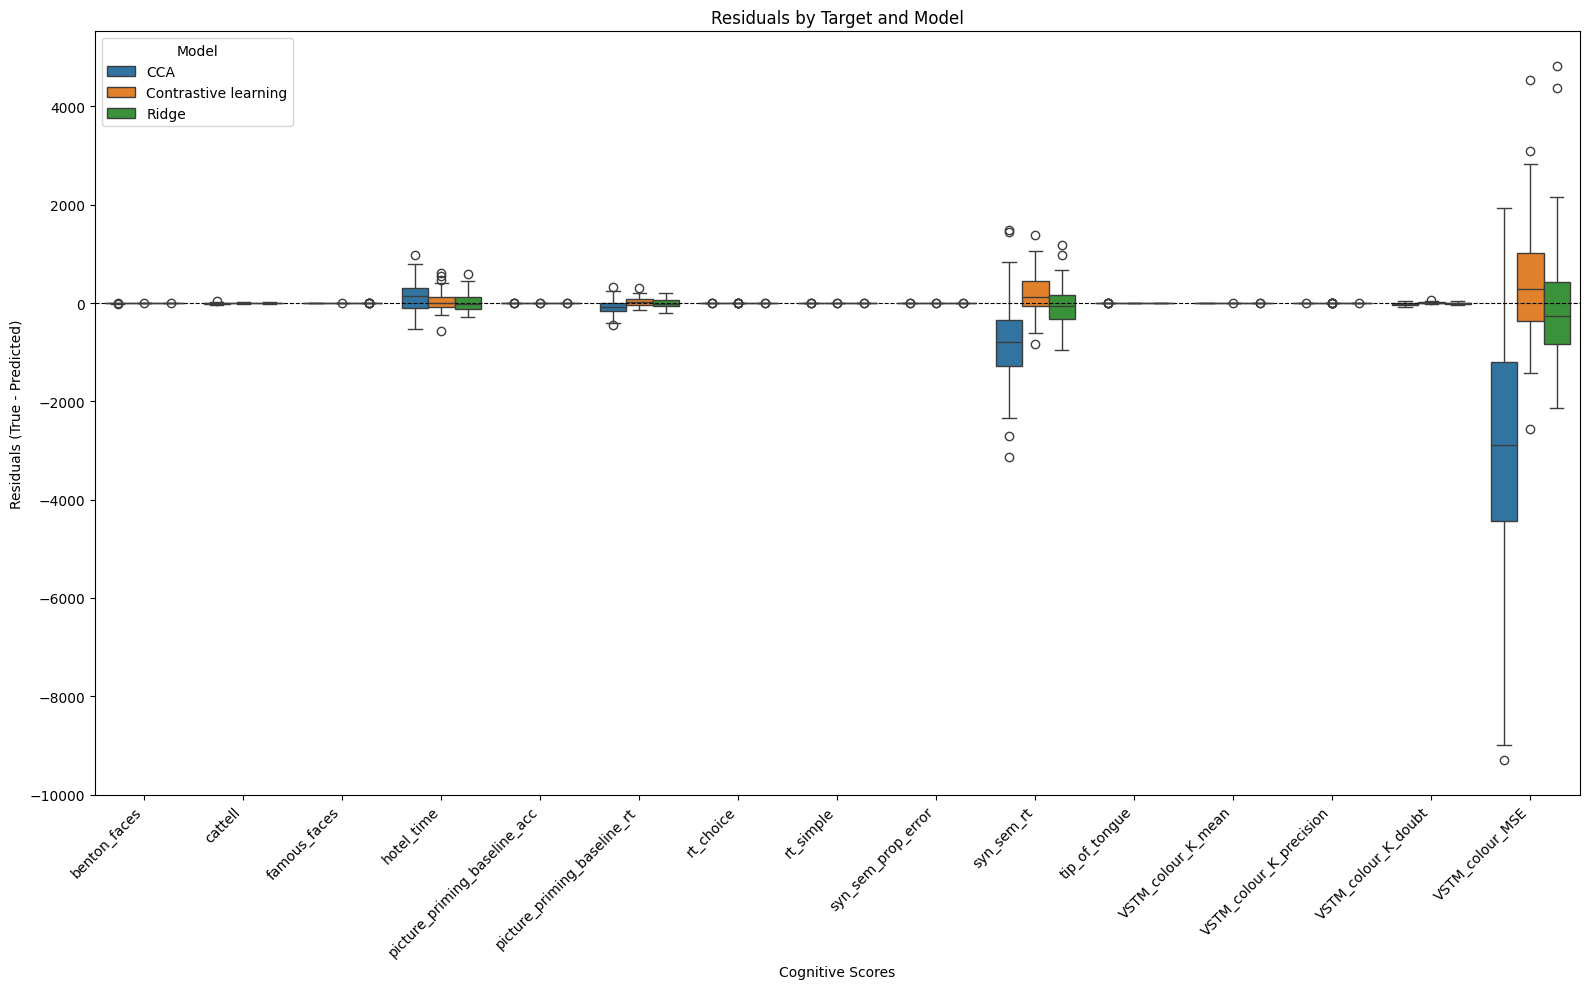

In [22]:
# Compute residuals for each target and model
residuals_list = []
for target in targets:
    for model, group in all_results.groupby("model"):
        test_data = group[group["dataset"] == "test"]
        if target in test_data.columns:
            residuals = test_data[target] - test_data[f"{target}_pred"]
            residuals_list.append(
                pd.DataFrame({
                    "residual": residuals,
                    "target": target,
                    "model": model
                })
            )

# Combine residuals into a single DataFrame
residuals_df = pd.concat(residuals_list, ignore_index=True)

# Plot residuals
plt.figure(figsize=(16, 10))

sns.boxplot(
    data=residuals_df,
    x="target",
    y="residual",
    hue="model",
    palette="tab10"
)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line at zero residual
plt.title("Residuals by Target and Model")
plt.ylabel("Residuals (True - Predicted)")
plt.xlabel("Cognitive Scores")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels to avoid overlap
plt.legend(title="Model", loc="upper left")

plt.tight_layout()
plt.show()



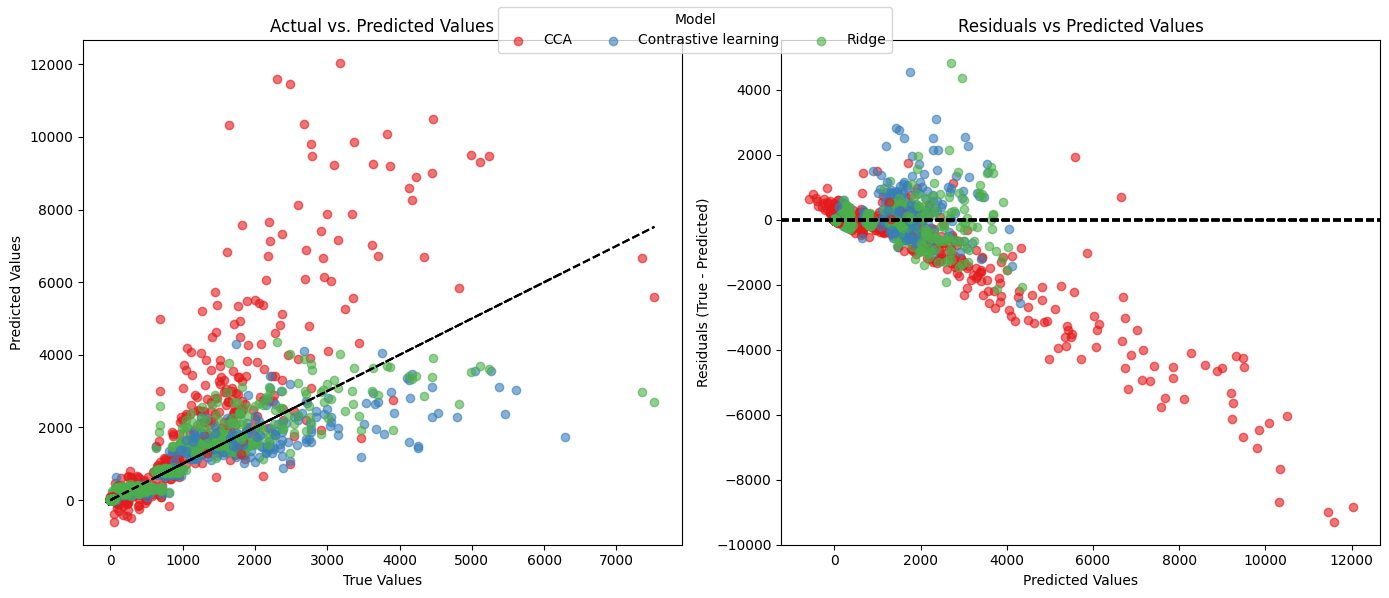

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define a color palette to assign a unique color to each model
palette = sns.color_palette("Set1", n_colors=len(all_results["model"].unique()))

# Prepare for plotting
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

# Initialize empty lists to collect legend handles and labels
handles, labels = [], []

# Loop through each model and target
for target in targets:
    for i, (model, group) in enumerate(all_results.groupby("model")):
        test_data = group[group["dataset"] == "test"]
        
        if target in test_data.columns:
            true_values = test_data[target]
            predicted_values = test_data[f"{target}_pred"]
            residuals = true_values - predicted_values
            
            # Plot Actual vs Predicted
            scatter1 = axs[0].scatter(true_values, predicted_values, label=model, color=palette[i], alpha=0.6)
            axs[0].set_xlabel("True Values")
            axs[0].set_ylabel("Predicted Values")
            axs[0].set_title("Actual vs. Predicted Values")
            axs[0].plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], linestyle="--", color="k")
            
            # Plot Residuals vs Predicted
            scatter2 = axs[1].scatter(predicted_values, residuals, label=model, color=palette[i], alpha=0.6)
            axs[1].set_xlabel("Predicted Values")
            axs[1].set_ylabel("Residuals (True - Predicted)")
            axs[1].set_title("Residuals vs Predicted Values")
            axs[1].axhline(0, color="k", linestyle="--")

            # Collect handles and labels for the legend (only once per model)
            if model not in labels:
                handles.append(scatter1)
                labels.append(model)

# Add a shared legend for both plots
fig.legend(handles, labels, title="Model", loc="upper center", ncol=3)

# Adjust layout to ensure the figure and legend fit nicely
plt.tight_layout()
plt.show()




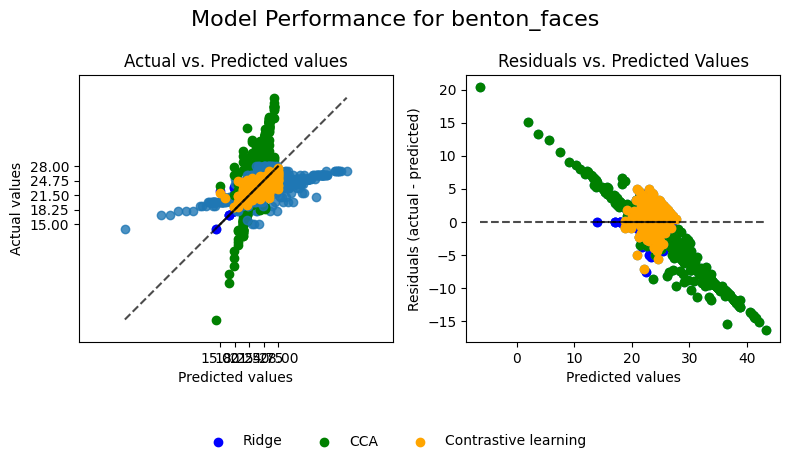

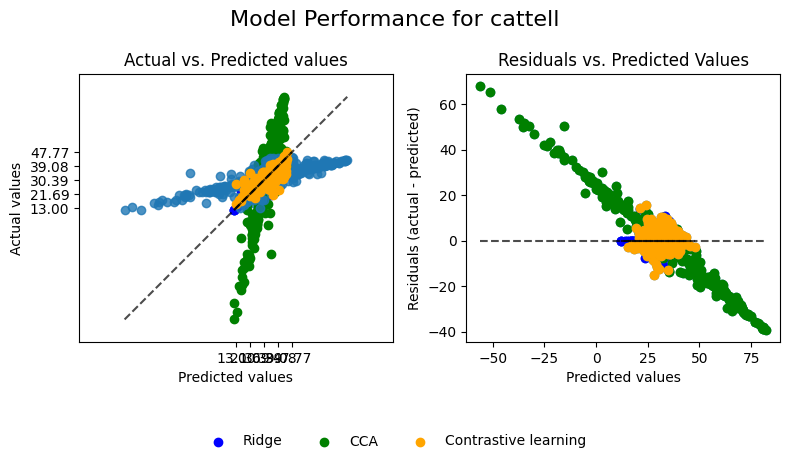

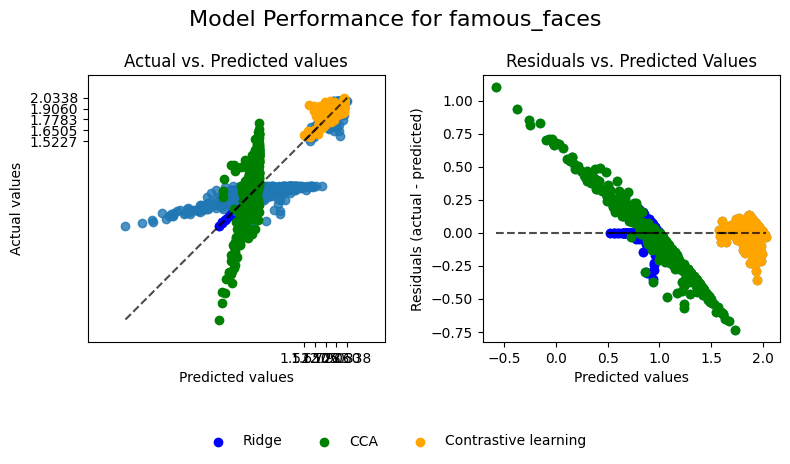

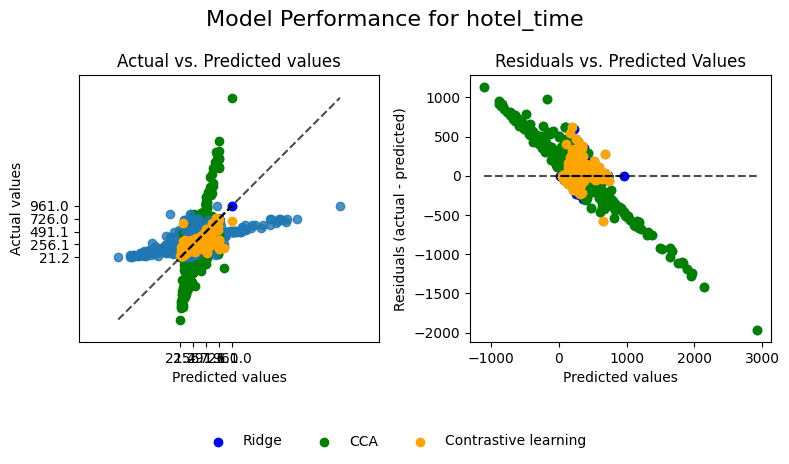

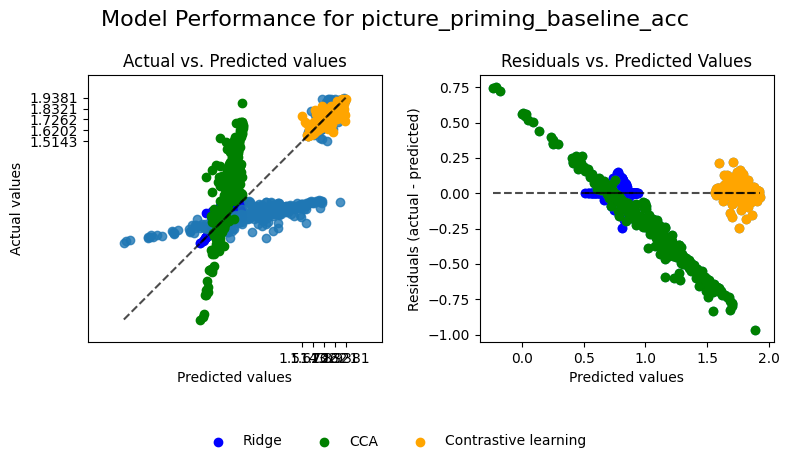

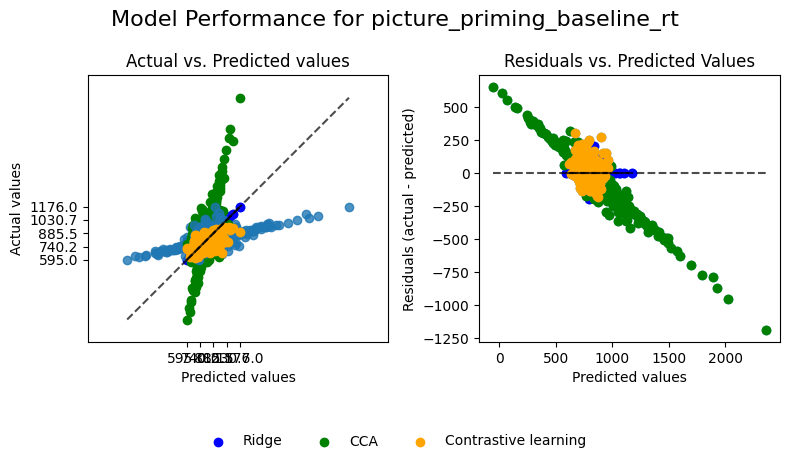

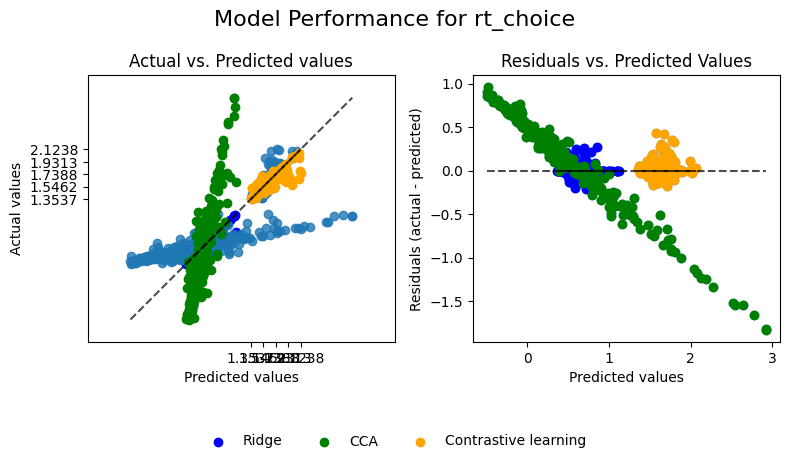

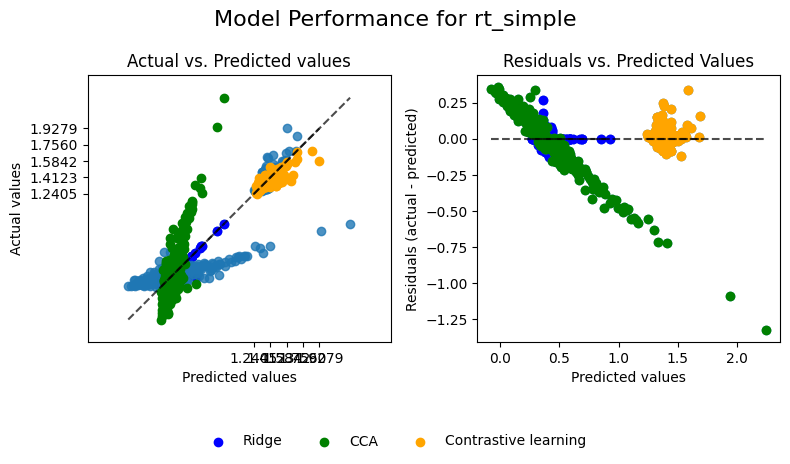

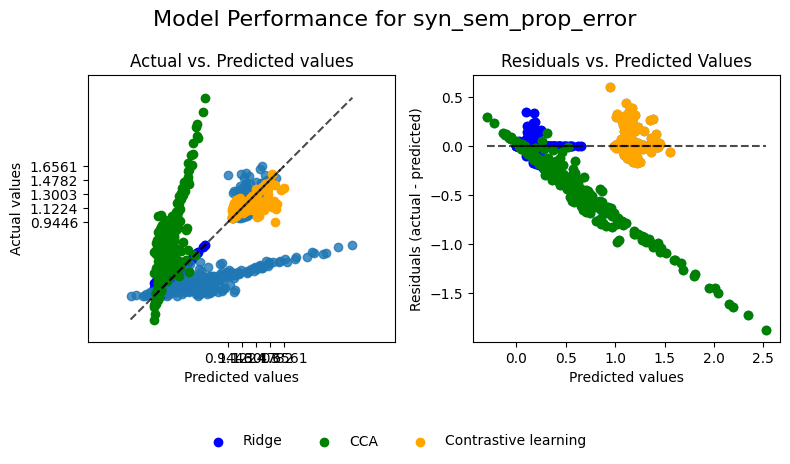

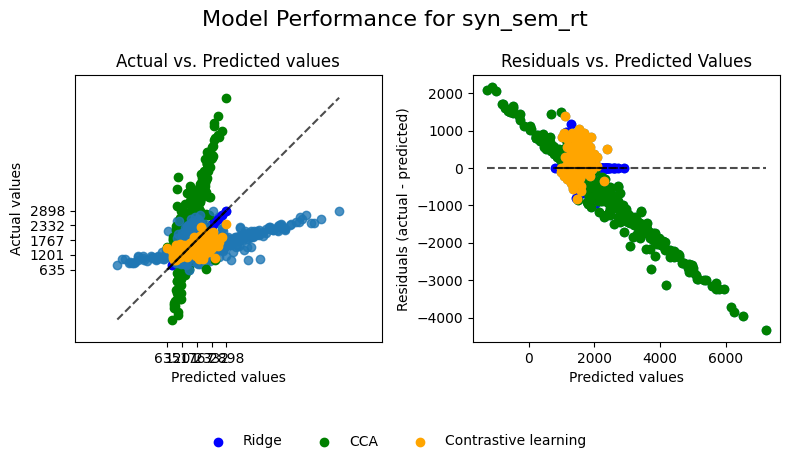

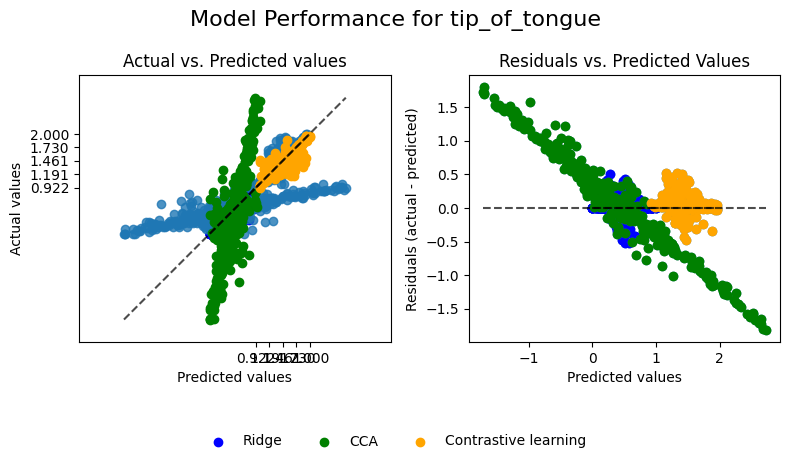

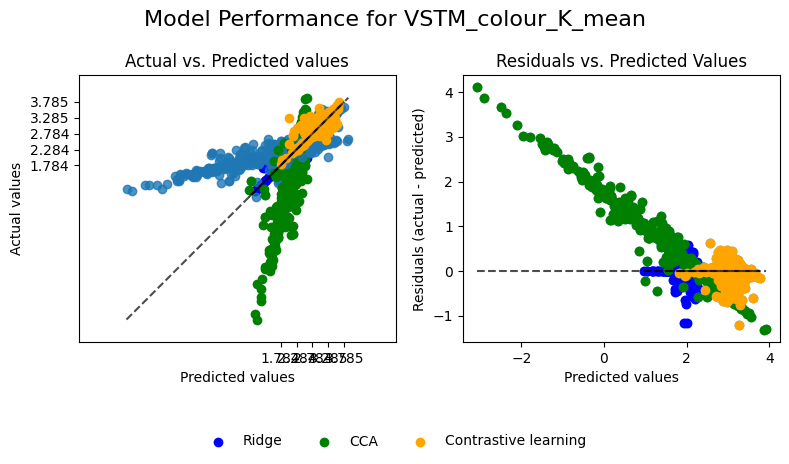

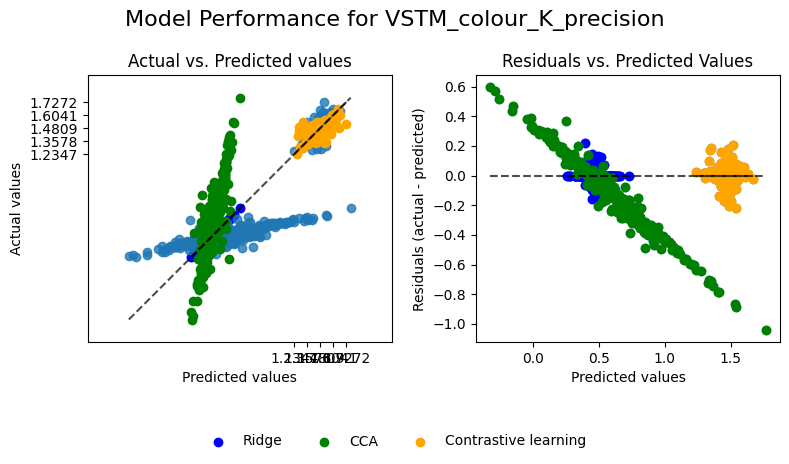

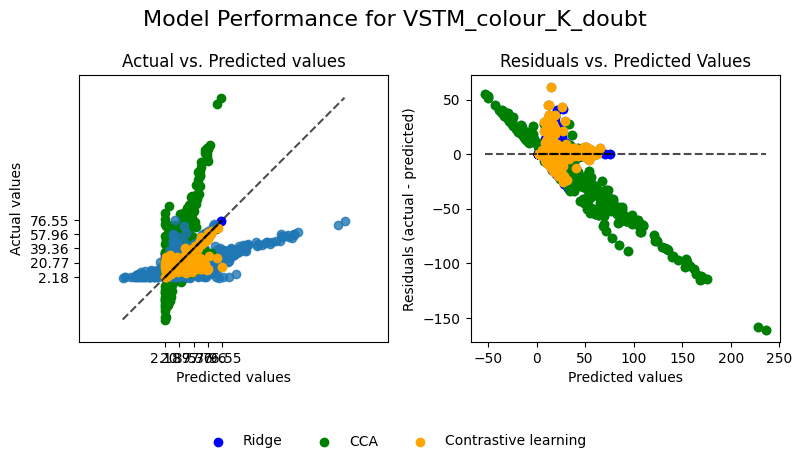

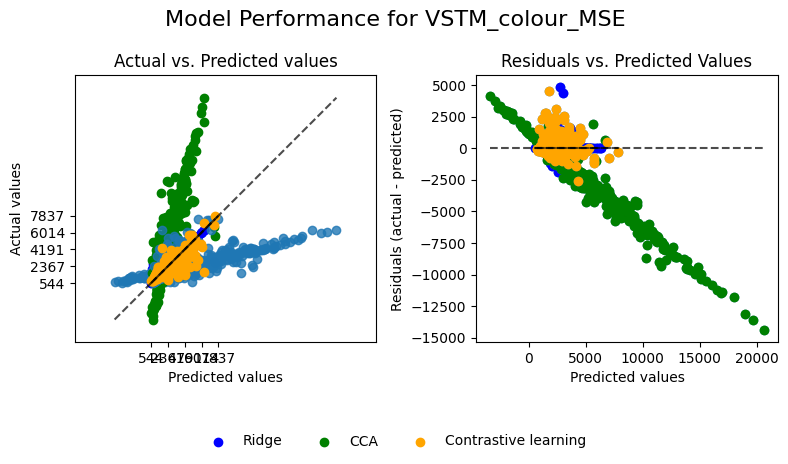

In [39]:
from sklearn.metrics import PredictionErrorDisplay
import matplotlib.pyplot as plt

# Define a color map for the datasets
dataset_colors = {
    "Ridge": "blue", 
    "CCA": "green", 
    "Contrastive learning": "orange"
}

# Loop over each target and create a figure for each
for target in targets:
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    
    # Loop through each model and plot the actual vs predicted and residuals vs predicted
    for model, color in dataset_colors.items():
        # Get the true values and predicted values for the current model
        model_data = all_results[all_results["model"] == model]  # Filter by model
        
        # Ensure target column exists and extract the actual and predicted values
        if target in model_data.columns and f"{target}_pred" in model_data.columns:
            y_test = model_data[target]  # Actual values for the current target and model
            y_pred = model_data[f"{target}_pred"]  # Predicted values for the current target and model

            # Plot Actual vs. Predicted values
            disp = PredictionErrorDisplay.from_predictions(
                y_test,
                y_pred=y_pred,
                kind="actual_vs_predicted",
                subsample=500,
                ax=axs[0],
                random_state=0
            )
            # Modify appearance: color and marker
            disp.ax_.scatter(y_test, y_pred, color=color, marker='o', label=model)
            
            # Plot Residuals vs. Predicted values
            disp = PredictionErrorDisplay.from_predictions(
                y_test,
                y_pred=y_pred,
                kind="residual_vs_predicted",
                subsample=500,
                ax=axs[1],
                random_state=0
            )
            # Modify appearance: color and marker
            disp.ax_.scatter(y_pred, y_test - y_pred, color=color, marker='o', label=model)

    # Set plot titles
    axs[0].set_title("Actual vs. Predicted values")
    axs[1].set_title("Residuals vs. Predicted Values")
    
    fig.suptitle(f"Model Performance for {target}", fontsize=16)
    
    # Add a single legend for both plots
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.05), frameon=False)
    
    # Adjust the layout to prevent overlap (leave space for the legend)
    plt.tight_layout()
    
    # Adjust subplots to make space for the legend
    plt.subplots_adjust(bottom=0.15)
    
    # Display the plots for the current target
    plt.show()




# Comparisons with different sample sizes

In [ ]:
#Contrastive learning prediction results
cr_pred_100 = pd.read_csv("results/final model 100 samples/pred_results.csv")
cr_pred_200 = pd.read_csv("results/final model 200 samples/pred_results.csv")
cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

## Preparing preds for CV Ridge regression and CCA

In [27]:
def prepare_data(dataset_path, targets):
    dataset = MatData(dataset_path, targets, synth_exp = False, threshold=0)

    n_sub = len(dataset)
    indices = np.arange(n_sub)

    train_size = int(n_sub * (1 - test_ratio) * train_ratio)
    test_size = int(test_ratio * n_sub)
    run_size = test_size + train_size

    random_state = np.random.RandomState(seed=42)
    run_indices = random_state.choice(indices, run_size, replace=False)
    train_indices, test_indices = train_test_split(run_indices, test_size=0.3, random_state=random_state)

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    X_train = train_dataset.dataset.matrices[train_dataset.indices].numpy()
    X_train = sym_matrix_to_vec(X_train, discard_diagonal=True)
    y_train = train_dataset.dataset.target[train_dataset.indices].squeeze().numpy()
    X_test = test_dataset.dataset.matrices[test_dataset.indices].numpy()
    X_test = sym_matrix_to_vec(X_test, discard_diagonal=True)
    y_test = test_dataset.dataset.target[test_dataset.indices].squeeze().numpy()

    return X_train, y_train, X_test, y_test
        

In [26]:
def ridge_pred(X_train, y_train, X_test, y_test) :
    
    ridge_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10**(1/np.arange(-3, -1))}, cv=5,
            scoring="r2")

    pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', ridge_estimator)])

    fitted_pipe = pipe_ridge.fit(X_train, y_train)

    y_train_pred = fitted_pipe.predict(X_train)
    y_test_pred = fitted_pipe.predict(X_test)

    train_df = pd.DataFrame(y_train, columns=targets)
    train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
    train_results_df = pd.concat([train_df, train_pred_df], axis=1)
    train_results_df["dataset"] = "train"

    test_df = pd.DataFrame(y_test, columns=targets)
    test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
    test_results_df = pd.concat([test_df, test_pred_df], axis=1)
    test_results_df["dataset"] = "test"

    # Combine train and test results into a single DataFrame
    return pd.concat([train_results_df, test_results_df]).reset_index(drop=True)

In [29]:
def cca_pred(X_train, y_train, X_test, y_test):
    n_components = min(len(targets), X_train.shape[1])  
    pipe_cca = Pipeline([
        ('scaler', StandardScaler()),  
        ('cca', CCA(n_components=n_components))
    ])

    pipe_cca.fit(X_train, y_train)
    cca_model = pipe_cca.named_steps['cca']

    y_train_pred = cca_model.predict(X_train)
    y_test_pred = cca_model.predict(X_test)
    
    train_df = pd.DataFrame(y_train, columns=targets)
    train_pred_df = pd.DataFrame(y_train_pred, columns=[f"{target}_pred" for target in targets])
    train_results_df = pd.concat([train_df, train_pred_df], axis=1)
    train_results_df["dataset"] = "train"

    test_df = pd.DataFrame(y_test, columns=targets)
    test_pred_df = pd.DataFrame(y_test_pred, columns=[f"{target}_pred" for target in targets])
    test_results_df = pd.concat([test_df, test_pred_df], axis=1)
    test_results_df["dataset"] = "test"

    return pd.concat([train_results_df, test_results_df]).reset_index(drop=True)


### 100 samples

/tmp/ipykernel_767230/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


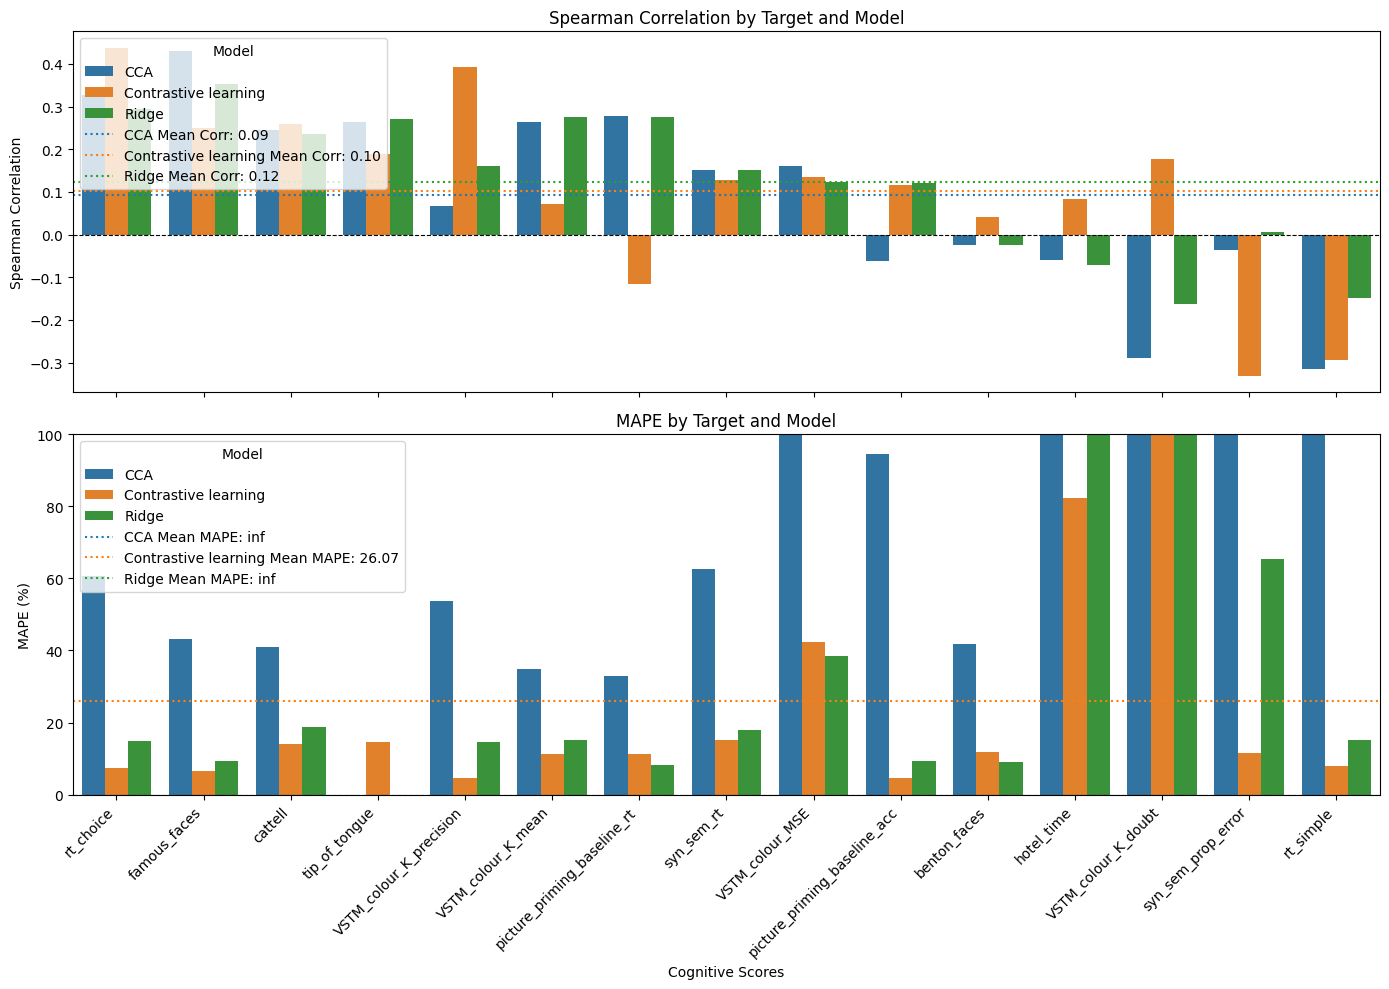

In [42]:
dataset_path = f"{root}/new_dataset_100_subjects.nc"

targets = ["benton_faces","cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_100 = ridge_pred(X_train, y_train, X_test, y_test)

cca_100 = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_100 = pd.read_csv("results/final model 100 samples/pred_results.csv")

plot_scores(ridge_100, cca_100, cr_pred_100, targets)


/tmp/ipykernel_767230/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


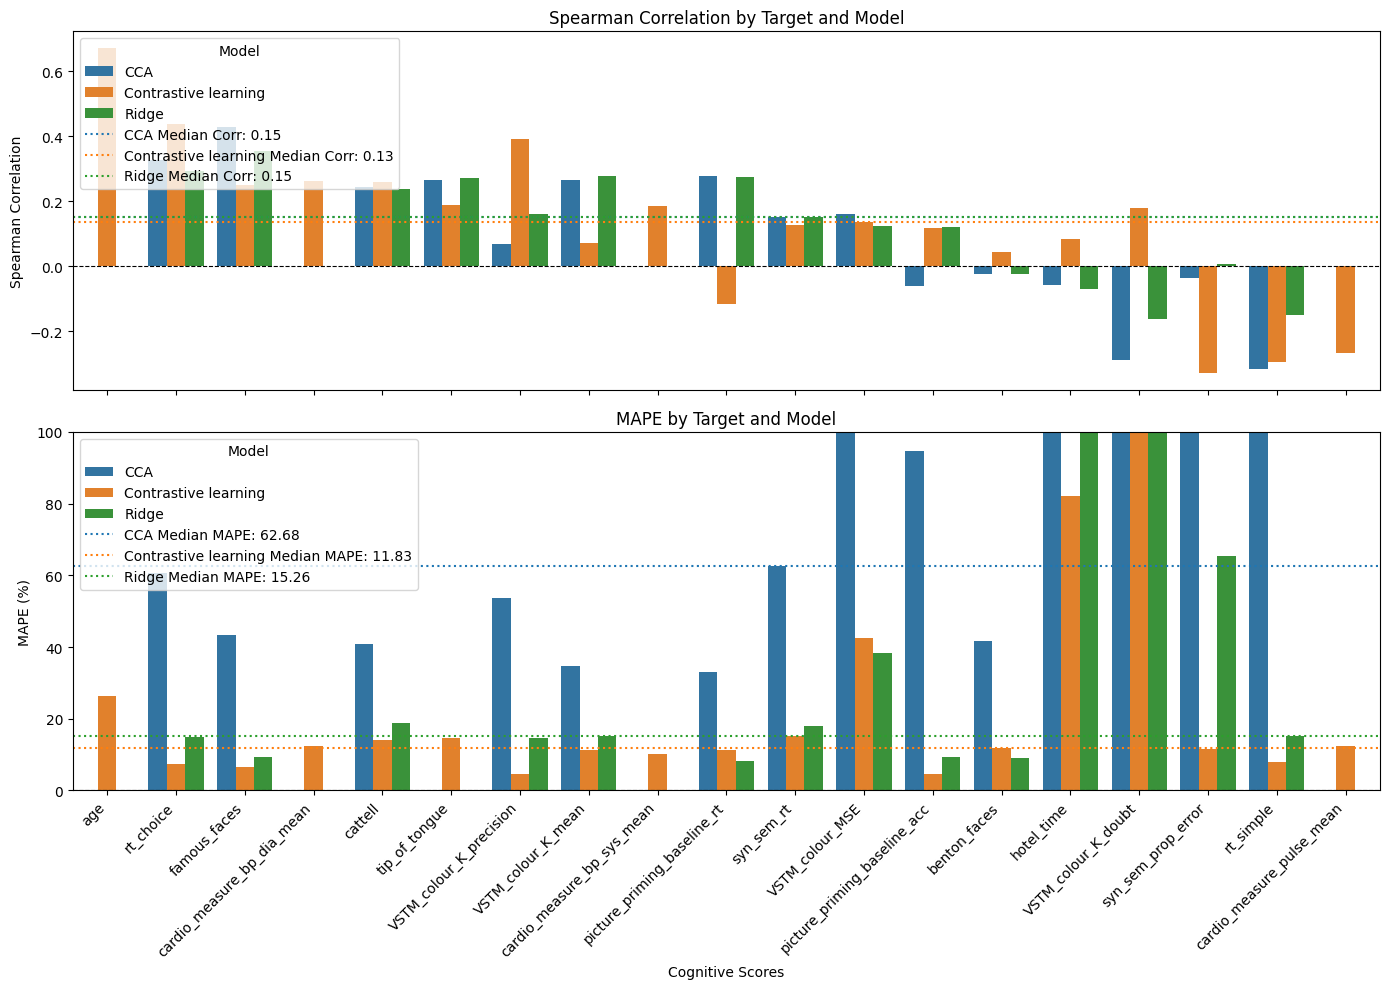

In [48]:
plot_median_scores(ridge_100, cca_100, cr_pred_100, targets)


### 200 samples

/tmp/ipykernel_767230/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


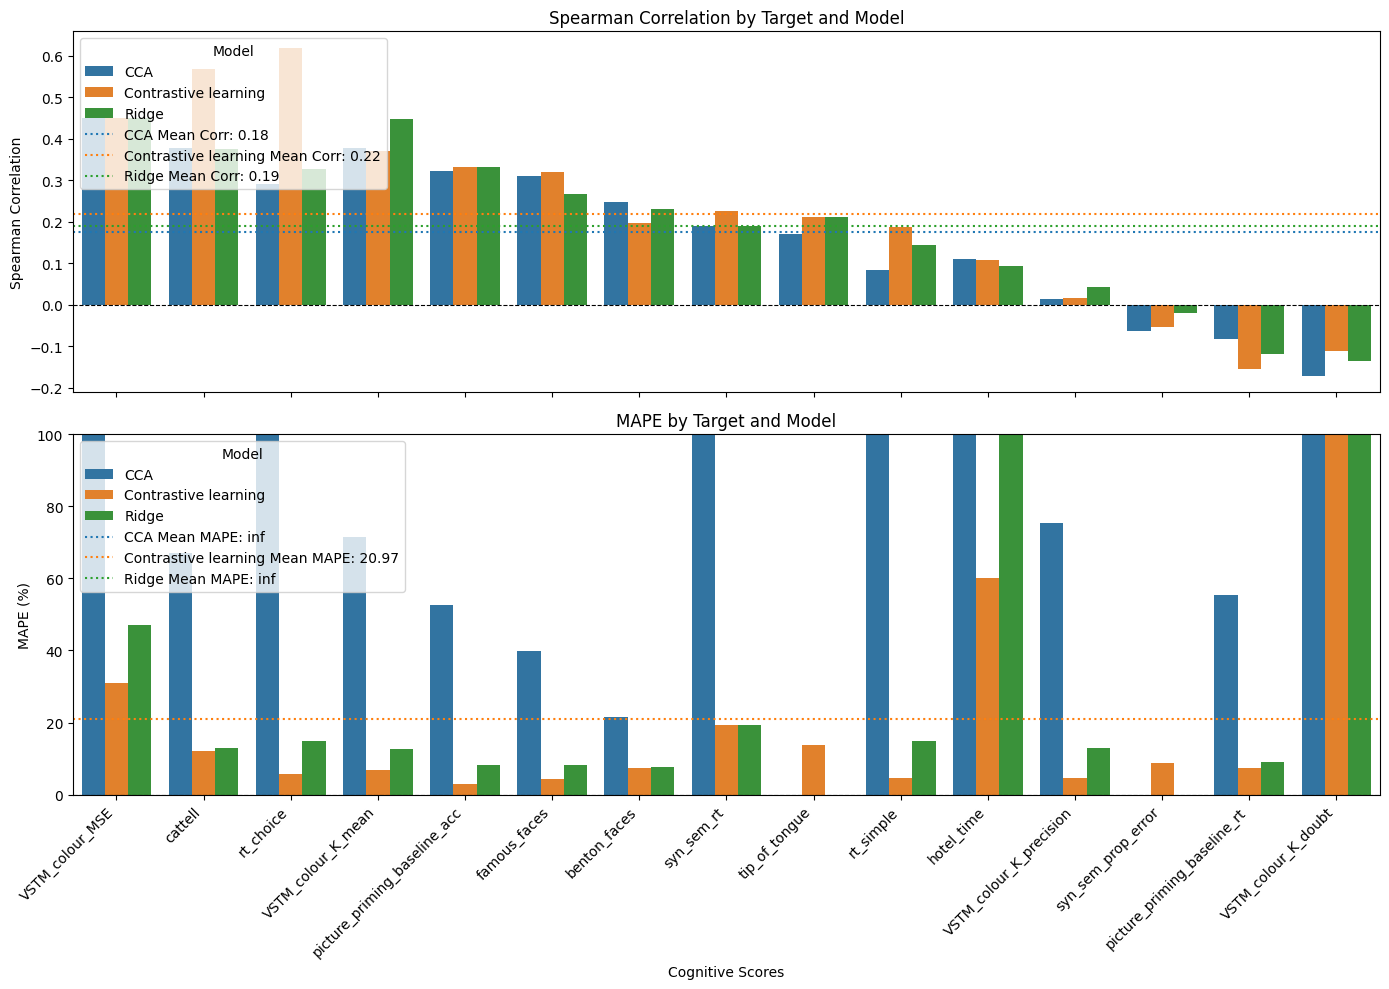

In [43]:
dataset_path = f"{root}/new_dataset_200_subjects.nc"

targets = ["benton_faces","cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_200 = ridge_pred(X_train, y_train, X_test, y_test)

cca_200 = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_200 = pd.read_csv("results/final model 200 samples/pred_results.csv")

plot_scores(ridge_200, cca_200, cr_pred_200, targets)


/tmp/ipykernel_767230/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


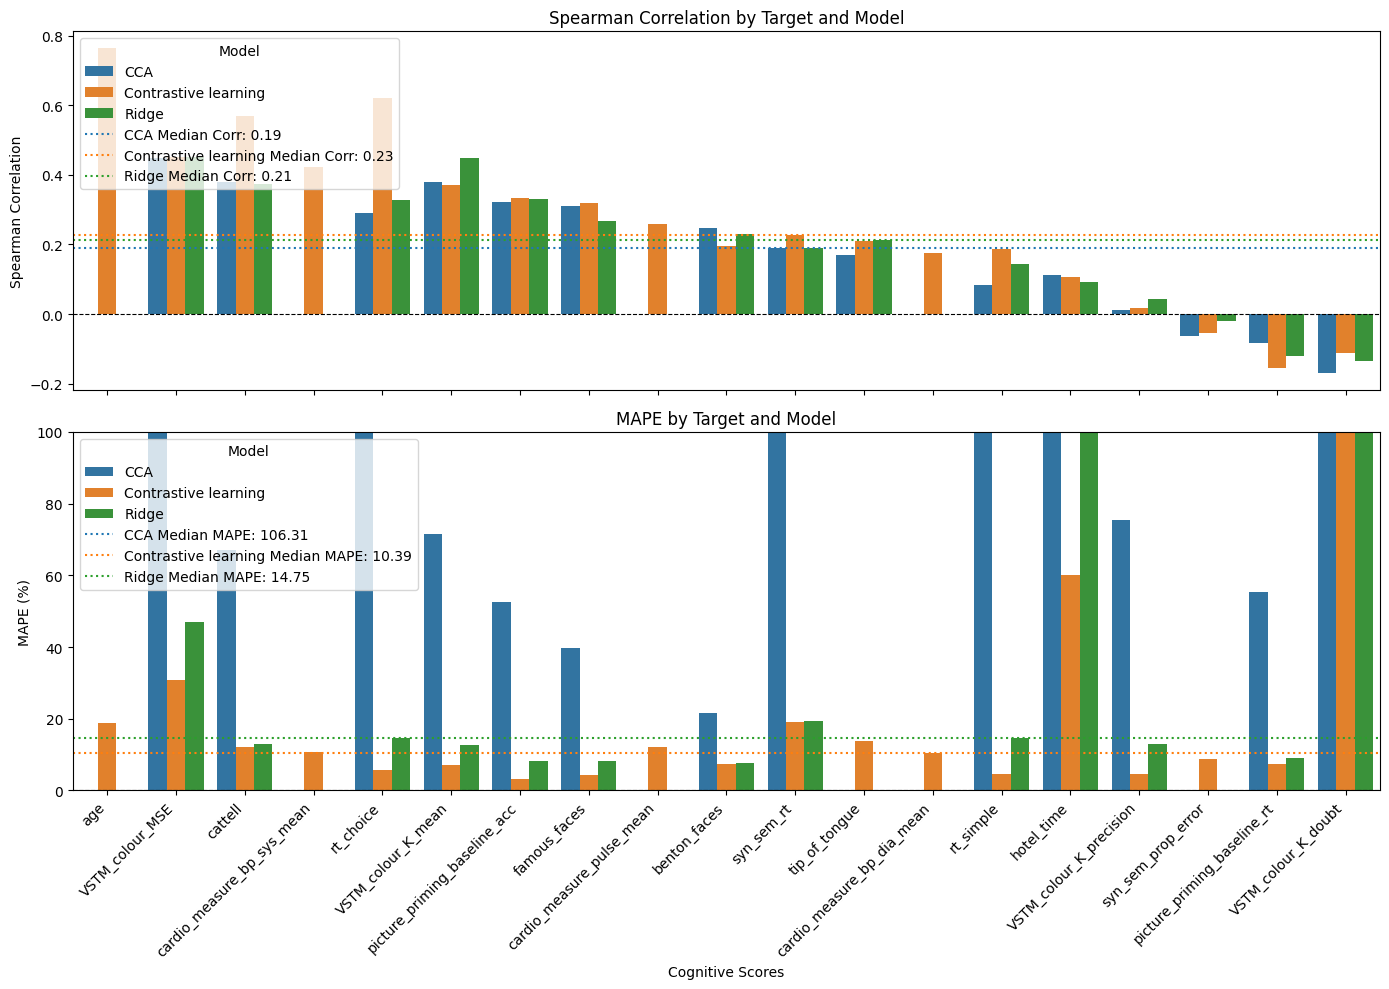

In [49]:
plot_median_scores(ridge_200, cca_200, cr_pred_200, targets)

## Whole dataset

/tmp/ipykernel_767230/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


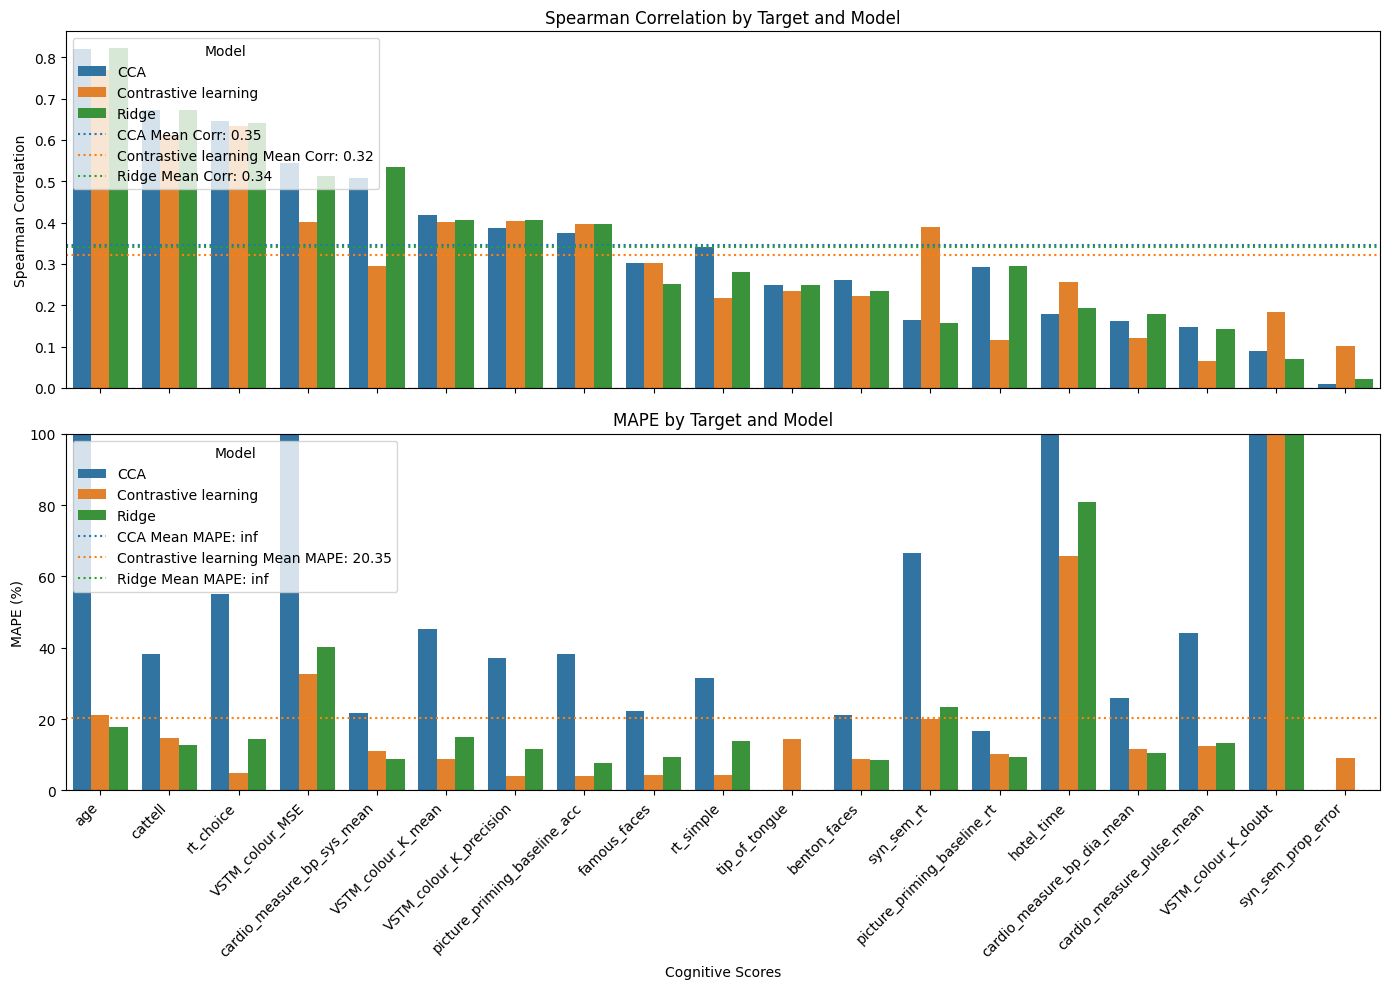

In [54]:
dataset_path = f"{root}/dataset_400parcels_2.nc"

targets = ["age","benton_faces","cardio_measure_pulse_mean","cardio_measure_bp_sys_mean",
            "cardio_measure_bp_dia_mean", "cattell", "famous_faces", "hotel_time",
           "picture_priming_baseline_acc", "picture_priming_baseline_rt", "rt_choice",
           "rt_simple", "syn_sem_prop_error", "syn_sem_rt", "tip_of_tongue", "VSTM_colour_K_mean",
           "VSTM_colour_K_precision", "VSTM_colour_K_doubt", "VSTM_colour_MSE"]

X_train, y_train, X_test, y_test = prepare_data(dataset_path, targets)

ridge_whole = ridge_pred(X_train, y_train, X_test, y_test)

cca_whole = cca_pred(X_train, y_train, X_test, y_test)

cr_pred_whole = pd.read_csv("results/strong pretraining, 4 layer decoder, 19 targets, 3 augmentations/pred_results.csv")

plot_scores(ridge_whole, cca_whole, cr_pred_whole, targets)

In [55]:
cr_pred_2 = pd.read_csv("/data/parietal/store2/work/mrenaudi/contrastive-reg-3/results/final model dataset 3/pred_results.csv")

/tmp/ipykernel_767230/313208744.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


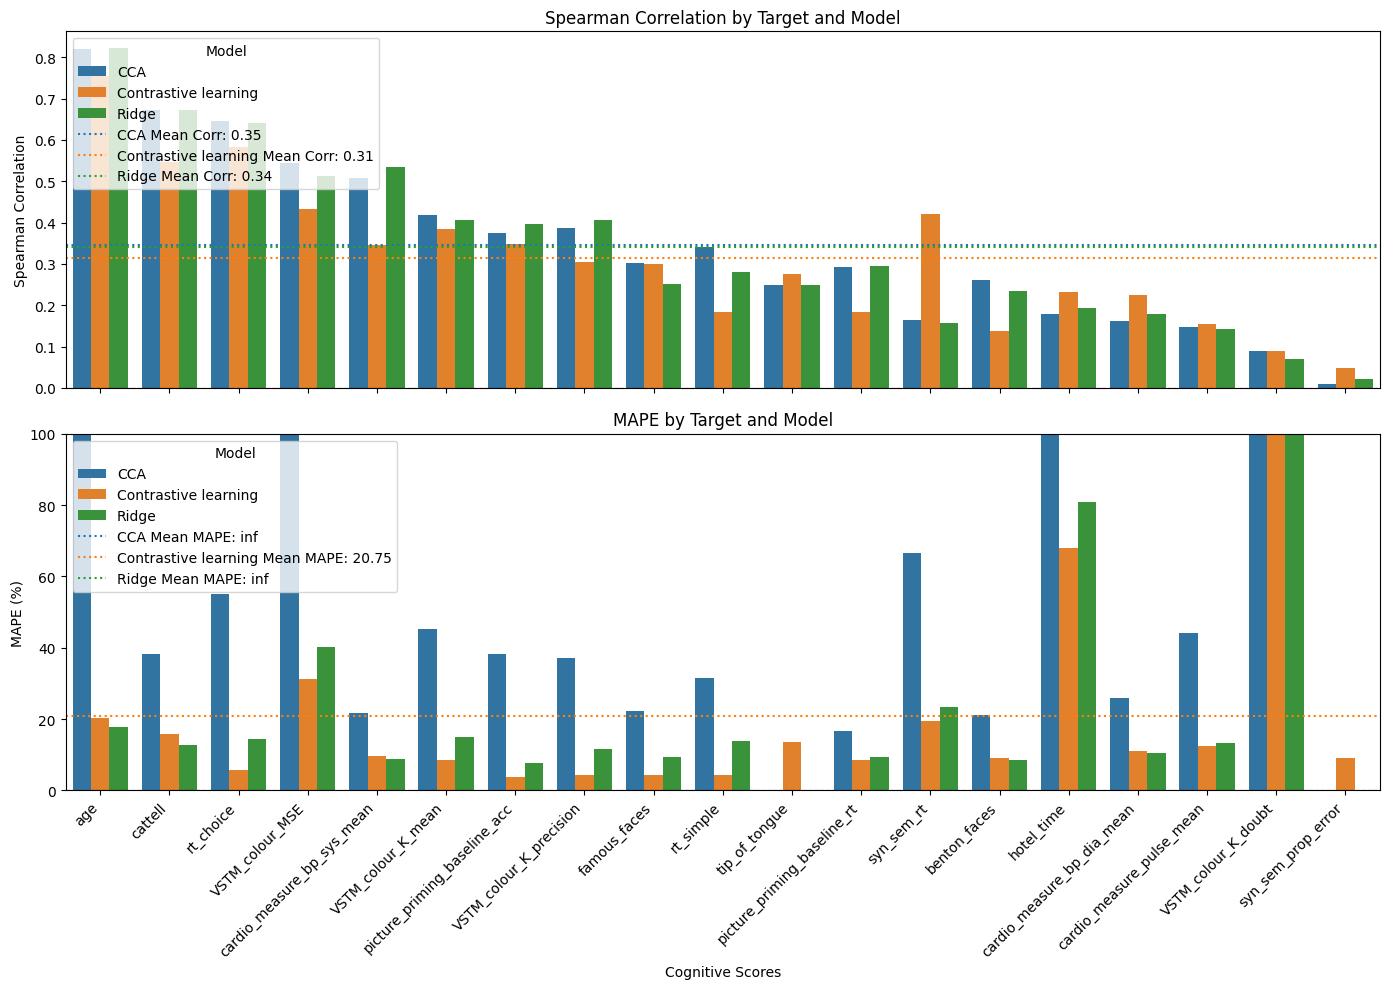

In [57]:
plot_scores(ridge_whole, cca_whole, cr_pred_2, targets)

/tmp/ipykernel_767230/1003462680.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


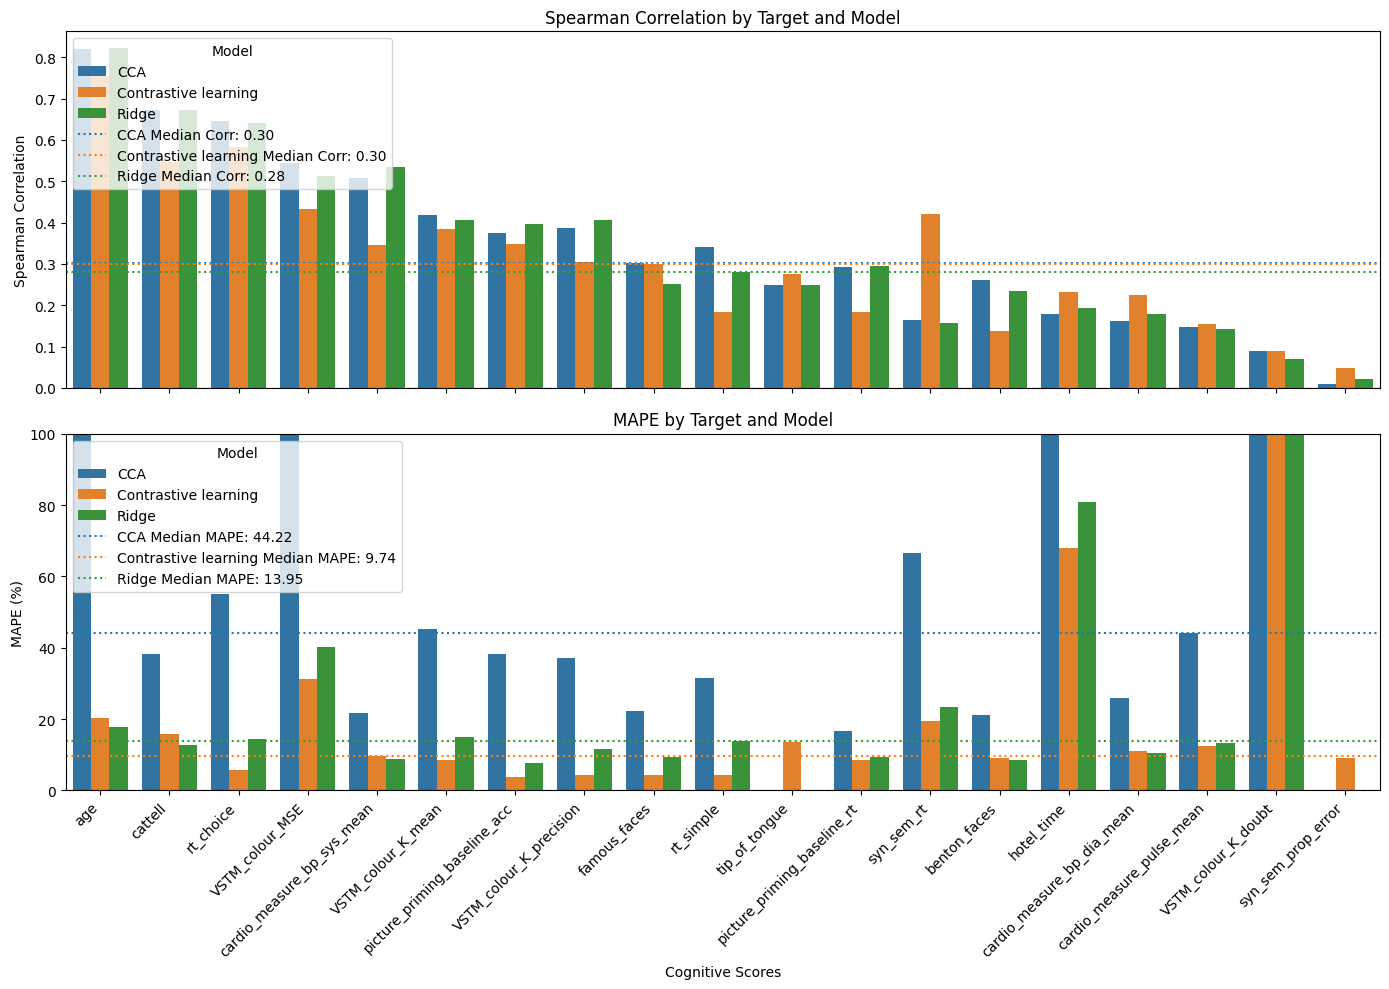

In [56]:
plot_median_scores(ridge_whole, cca_whole, cr_pred_2, targets)

## Plotting with several dataset sizes

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns

def plot_scores_3d(ridge, cca, model, targets, dataset_sizes):
    all_results = pd.concat(
        [
            ridge.assign(model="Ridge"),
            cca.assign(model="CCA"),
            model.assign(model="Contrastive learning"),
        ],
        ignore_index=True,
    )

    # Prepare results for each dataset size
    results = []
    for model, group in all_results.groupby("model"):
        for dataset_size in dataset_sizes:
            subset = group[group["dataset_size"] == dataset_size]

            for target in targets:
                if target in subset.columns:
                    true_values = subset[target]
                    predicted_values = subset[f"{target}_pred"]

                    if not true_values.isna().all() and not predicted_values.isna().all():
                        # Spearman correlation
                        spearman_corr = spearmanr(true_values, predicted_values)[0]
                        # MAPE (Mean Absolute Percentage Error)
                        mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

                        results.append(
                            {"model": model, "target": target, "dataset_size": dataset_size,
                             "spearman_corr": spearman_corr, "mape": mape}
                        )

    results_df = pd.DataFrame(results)

    # 3D Plot for Spearman Correlation
    fig = plt.figure(figsize=(14, 12))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Plot Spearman correlation
    for model, group in results_df.groupby("model"):
        ax1.scatter(
            group["dataset_size"], group["target"], group["spearman_corr"],
            label=model, s=50, alpha=0.7
        )

    ax1.set_title("Spearman Correlation by Dataset Size, Target, and Model")
    ax1.set_xlabel("Dataset Size")
    ax1.set_ylabel("Target")
    ax1.set_zlabel("Spearman Correlation")
    ax1.legend(title="Model")

    # Plot MAPE
    for model, group in results_df.groupby("model"):
        ax2.scatter(
            group["dataset_size"], group["target"], group["mape"],
            label=model, s=50, alpha=0.7
        )

    ax2.set_title("MAPE by Dataset Size, Target, and Model")
    ax2.set_xlabel("Dataset Size")
    ax2.set_ylabel("Target")
    ax2.set_zlabel("MAPE (%)")
    ax2.legend(title="Model")

    plt.tight_layout()
    plt.show()
